In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
# print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

In [2]:
import time
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
sns.set()
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)


## 1. Overview
As stated in the description, the data for this competition comes from a experimental set-up used to study earthquake physics. Our goal is to predict the time remaining before the next laboratory earthquake. The only feature we have is the seismic signal (acoustic data) which has integer values in a limited range.

Training data: single, continuous segment of experimental data.

Test data: consists of a folder containing many small segments. The data within each test file is continuous, but the test files do not represent a continuous segment of the experiment.

There are a lot of files in this competition, so let's start with the folders structure:

In [3]:
print(os.listdir("../input/"))

FileNotFoundError: [WinError 3] The system cannot find the path specified: '../input/'

The test folder has 2624 csv files (segments):

In [4]:
test_folder_files = os.listdir("../input/test")
print(test_folder_files[:10])  # print first 10
print("\nNumber of files in the test folder", len(test_folder_files))

['seg_0b082e.csv', 'seg_9e7dff.csv', 'seg_b6c10d.csv', 'seg_4435bd.csv', 'seg_c09a41.csv', 'seg_31ddc5.csv', 'seg_71238c.csv', 'seg_6a05e7.csv', 'seg_d47aba.csv', 'seg_eea20e.csv']

Number of files in the test folder 2624


Each segment contains 150,000 acoustic records:

In [5]:
test_file = pd.read_csv('../input/test/seg_0b082e.csv')
print("Segment shape", test_file.shape)
test_file.head()

Segment shape (150000, 1)


,acoustic_data
0,3
1,10
2,4
3,4
4,1


There is one file in the test folder for each prediction (seg_id) in sample_submission:

In [6]:
sample_sub = pd.read_csv('../input/sample_submission.csv')
print("Submission shape", sample_sub.shape)
sample_sub.head()

Submission shape (2624, 2)


,seg_id,time_to_failure
0,seg_00030f,0
1,seg_0012b5,0
2,seg_00184e,0
3,seg_003339,0
4,seg_0042cc,0


## 2. Training data
One huge csv file has all the training data, which is a single continuous experiment. There are only two columns in this file:

Acoustic data (int16): the seismic signal
Time to failure (float64): the time until the next laboratory earthquake (in seconds)
No missing values for both columns

In [7]:
%%time
train = pd.read_csv('../input/train.csv', dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32})

CPU times: user 2min 22s, sys: 33.2 s, total: 2min 56s
Wall time: 2min 56s


In [8]:
pd.set_option("display.precision", 15)  # show more decimals
train.head()

,acoustic_data,time_to_failure
0,12,1.469099998474121
1,6,1.469099998474121
2,8,1.469099998474121
3,5,1.469099998474121
4,8,1.469099998474121


In [9]:
print('The training data has {} rows and {} columns'.format(train.shape[0],train.shape[1]))


The training data has 629145480 rows and 2 columns


### Acoustic data
Our single feature are integers in the range [-5515, 5444] with mean 4.52

In [10]:
pd.set_option("display.precision", 8)
train.acoustic_data.describe()

count    6.29145480e+08
mean     4.51946757e+00
std      1.07357072e+01
min     -5.51500000e+03
25%      2.00000000e+00
50%      5.00000000e+00
75%      7.00000000e+00
max      5.44400000e+03
Name: acoustic_data, dtype: float64

The plot below is using a 1% random sample (~6M rows):

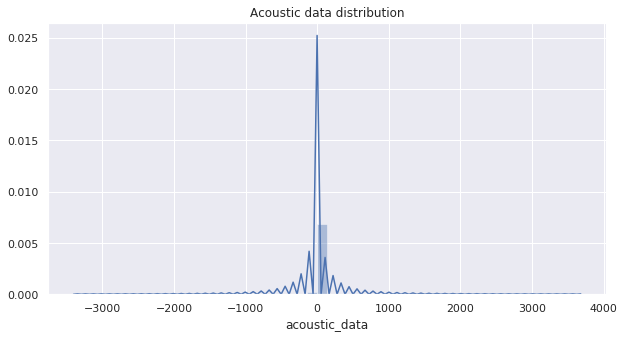

In [11]:
train_sample = train.sample(frac=0.01)
plt.figure(figsize=(10,5))
plt.title("Acoustic data distribution")
ax = sns.distplot(train_sample.acoustic_data, label='Train (1% sample)')
del train_sample

There are outliers in both directions; let's try to plot the same distribution with x in the range -20 to 30. The black line is the closest normal distribution (gaussian) possible.

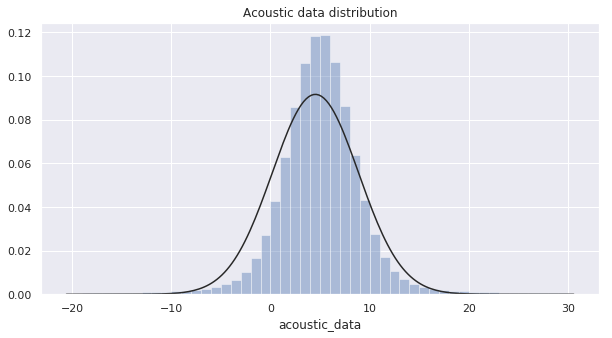

In [12]:
train_sample = train.sample(frac=0.01)
plt.figure(figsize=(10,5))
plt.title("Acoustic data distribution")
tmp = train_sample[train_sample.acoustic_data.between(-20, 30)]
ax = sns.distplot(tmp.acoustic_data, label='Train (1% sample)', kde=False, fit=stats.norm)
#del train_sample

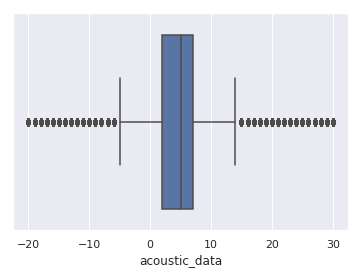

In [13]:
import seaborn as sns
sns.boxplot(x = tmp.acoustic_data)

## Time to failure
Now let's check the target variable, which is given in seconds:

In [14]:
train.time_to_failure.describe()

count    6.29145480e+08
mean     4.47708428e-01
std      2.61278939e+00
min      9.55039650e-05
25%      2.62599707e+00
50%      5.34979773e+00
75%      8.17339516e+00
max      1.61074009e+01
Name: time_to_failure, dtype: float64

The min value is very close to zero (around 10^-5) and the max is 16 seconds. Now the distribution for the random sample:

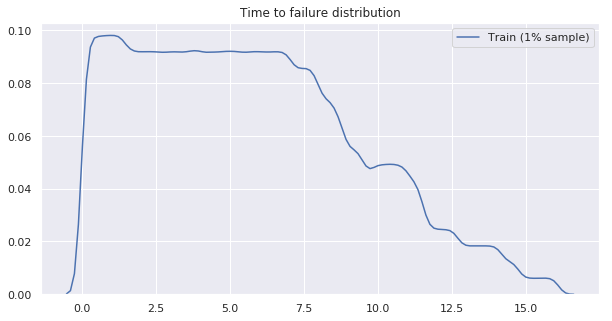

In [15]:
plt.figure(figsize=(10,5))
plt.title("Time to failure distribution")
ax = sns.kdeplot(train_sample.time_to_failure, label='Train (1% sample)')

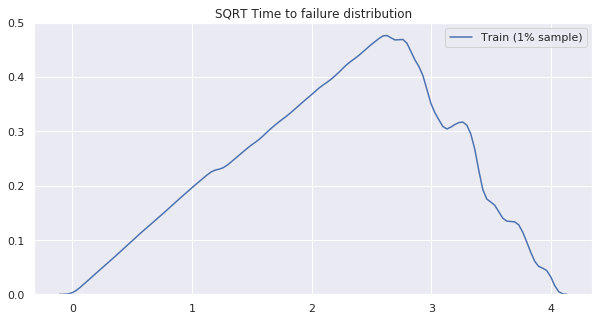

In [16]:
train_sample = train.sample(frac=0.01)
sqrt_time = np.sqrt(train_sample.time_to_failure)
plt.figure(figsize=(10,5))
plt.title("SQRT Time to failure distribution")
ax = sns.kdeplot(sqrt_time, label='Train (1% sample)')

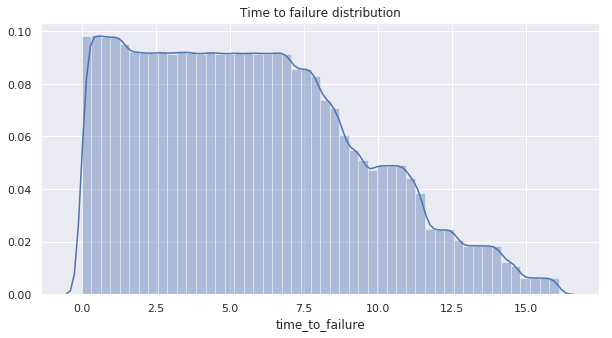

In [17]:
train_sample = train.sample(frac=0.01)
plt.figure(figsize=(10,5))
plt.title("Time to failure distribution")
ax = sns.distplot(train_sample.time_to_failure, label='Train (1% sample)')
del train_sample

## Timeseries
Let's see how both variables change over time. The red line is the acoustic data and the blue one is the time to failure:

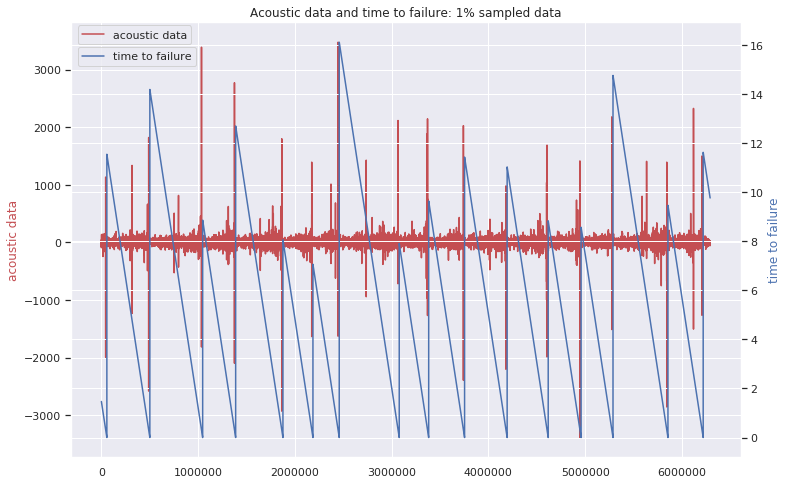

In [18]:
train_ad_sample_df = train['acoustic_data'].values[::100]
train_ttf_sample_df = train['time_to_failure'].values[::100]

def plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df, title="Acoustic data and time to failure: 1% sampled data"):
    fig, ax1 = plt.subplots(figsize=(12, 8))
    plt.title(title)
    plt.plot(train_ad_sample_df, color='r')
    ax1.set_ylabel('acoustic data', color='r')
    plt.legend(['acoustic data'], loc=(0.01, 0.95))
    ax2 = ax1.twinx()
    plt.plot(train_ttf_sample_df, color='b')
    ax2.set_ylabel('time to failure', color='b')
    plt.legend(['time to failure'], loc=(0.01, 0.9))
    plt.grid(True)

plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df)


On a plot above we can see, that training data has 16 earthquakes. The shortest time to failure is 1.5 seconds for the first earthquake and 7seconds for the 7th, while the longest is around 16 seconds.
* We can see that usually acoustic data shows huge fluctuations just before the failure and the nature of data is cyclical;
* Another important point: visually failures can be predicted as cases when huge fluctuations in signal are followes by small signal values. This could be useful for predicting "time_to_failure" changes from 0 to high values;

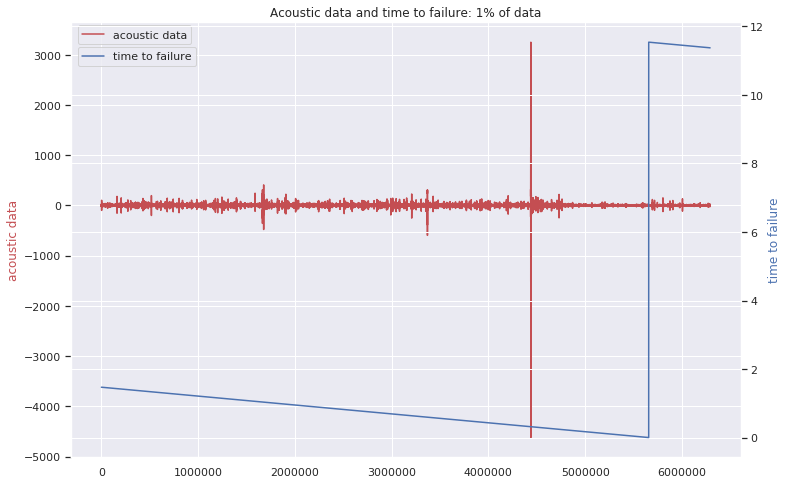

In [19]:
train_ad_sample_df_2 = train['acoustic_data'].values[:6291455]
train_ttf_sample_df_2 = train['time_to_failure'].values[:6291455]
plot_acc_ttf_data(train_ad_sample_df_2, train_ttf_sample_df_2, title="Acoustic data and time to failure: 1% of data")
del train_ad_sample_df_2
del train_ttf_sample_df_2

On this zoomed-in-time plot we can see that actually the large oscilation before the failure is not quite in the last moment. There are also trains of intense oscilations preceeding the large one and also some oscilations with smaller peaks after the large one. Then, after some minor oscilations, the failure occurs.
Interesting thing to check is the time between high levels of seismic signal and the earthquakes. We are considering any acoustic data with absolute value greater than 1000 as a high level:

In [20]:
peaks = train[train.acoustic_data.abs() > 1000]
peaks.time_to_failure.describe()

count    11325.00000000
mean         0.64454830
std          1.32147193
min          0.31079626
25%          0.31549615
50%          0.31689683
75%          0.32029617
max          8.86059952
Name: time_to_failure, dtype: float64

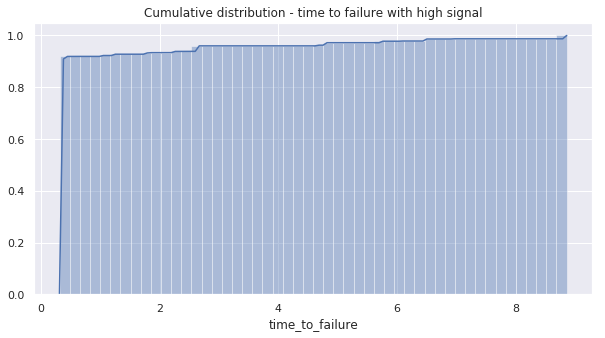

In [21]:
plt.figure(figsize=(10,5))
plt.title("Cumulative distribution - time to failure with high signal")
ax = sns.distplot(peaks.time_to_failure, hist_kws=dict(cumulative=True), kde_kws=dict(cumulative=True))
del peaks

**More than 90% of high acoustic values are around 0.31 seconds before an earthquake!**

array([1.4691   , 1.4690999, 1.4690998, ..., 9.759796 , 9.759796 ,
       9.759795 ], dtype=float32)

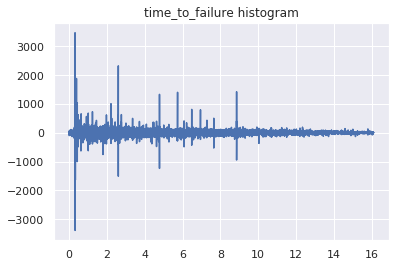

In [22]:
plt.plot(train_ttf_sample_df, train_ad_sample_df)
plt.title("time_to_failure histogram")
train_ad_sample_df
train_ttf_sample_df

Lets see the same plot as above, but without acustic outliers.

Text(0.5, 1.0, 'time_to_failure histogram')

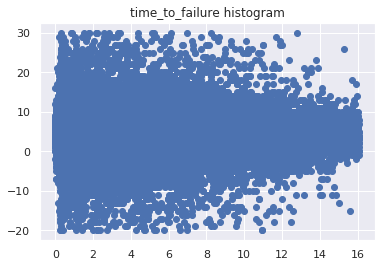

In [23]:
train_ad_sample_df = tmp['acoustic_data'].values[::100]
train_ttf_sample_df = tmp['time_to_failure'].values[::100]
plt.scatter(train_ttf_sample_df, train_ad_sample_df)
plt.title("time_to_failure histogram")

In [24]:
import gc
a = gc.collect()
del a

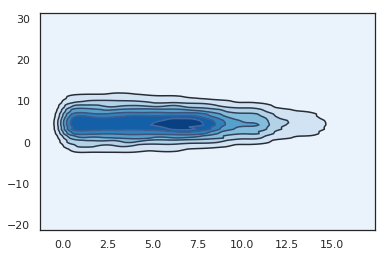

In [25]:
# library & dataset
import seaborn as sns
import matplotlib.pyplot as plt
 
# Basic 2D density plot
sns.set_style("white")
sns.kdeplot(train_ttf_sample_df, train_ad_sample_df)
#sns.plt.show()
 
# Custom it with the same argument as 1D density plot
sns.kdeplot(train_ttf_sample_df, train_ad_sample_df, cmap="Reds", shade=True, bw=.15)
 
# Some features are characteristic of 2D: color palette and wether or not color the lowest range
sns.kdeplot(train_ttf_sample_df, train_ad_sample_df, cmap="Blues", shade=True, shade_lowest=True, )
plt.show()


## Part I: We will divide the train data set for segments

Group the training data in chunks of 150,000 examples and extract the following features:


In [26]:
#The Amplitude Spectral Density ASDs are the square root of the power spectral densities (PSDs), 
#which are averages of the square of the fast fourier transforms (FFTs) of the data.

from scipy.fftpack import fft, rfft
import math
from tqdm import tqdm
from scipy.stats import moment
rows = 150_000
segments = int(np.floor(train.shape[0] / rows))

X_train = pd.DataFrame(index=range(segments), dtype=np.float64)
y_train = pd.DataFrame(index=range(segments), dtype=np.float64)

for segment in tqdm(range(segments)):
    seg = train.iloc[segment*rows:segment*rows+rows]
    #seg = seg[seg.acoustic_data.between(-20,30)]
    x = seg['acoustic_data']   # pd series
    y = seg['time_to_failure'].values[-1]  # single value
    
    #y_train.loc[segment, 'time_to_failure'] = np.log(y)
    y_train.loc[segment, 'time_to_failure'] = np.sqrt(y)
    
    I_ave10 = 0.1*len(x)
    II_ave10 = 0.2*len(x)
    III_ave10 = 0.3*len(x)
    IV_ave10 = 0.4*len(x)
    V_ave10 = 0.5*len(x)
    VI_ave10 = 0.6*len(x)
    VII_ave10 = 0.7*len(x)
    VIII_ave10 = 0.8*len(x)
    IX_ave10 = 0.9*len(x)
    
    
    X_train.loc[segment, 'rFFT mean'] = rfft(x).mean()
    X_train.loc[segment, 'rFFT std'] = rfft(x).std()
       
    X_train.loc[segment, '0<x<5'] = sum(x.between(0, 5))
    X_train.loc[segment, '5<x<10'] = sum(x.between(5, 10))    
    X_train.loc[segment, '10<x<20'] = sum(x.between(10, 20))
    X_train.loc[segment, '20<x<30'] = sum(x.between(20, 30))
    X_train.loc[segment, '30<x<100'] = sum(x.between(30, 100))
    X_train.loc[segment, '100<x<500'] = sum(x.between(100, 500))
    X_train.loc[segment, '500<x<1000'] = sum(x.between(500, 1000))
    X_train.loc[segment, '1000<x<5000'] = sum(x.between(1000, 5000))
    
    X_train.loc[segment, 'skewness'] = moment(x, moment=3)
    X_train.loc[segment, 'kurtosis'] = moment(x, moment=4)
    X_train.loc[segment, 'hypermoment'] = moment(x, moment=5)
    X_train.loc[segment, 'hypermoment2'] = moment(x, moment=6)
    X_train.loc[segment, 'ave'] = x.values.mean()
    X_train.loc[segment, 'std'] = x.values.std()
    X_train.loc[segment, 'max'] = x.values.max()
    X_train.loc[segment, 'min'] = x.values.min()
        
    X_train.loc[segment, 'q90'] = np.quantile(x.values, 0.90)
    X_train.loc[segment, 'q95'] = np.quantile(x.values, 0.95)
    X_train.loc[segment, 'q99'] = np.quantile(x.values, 0.99)
    X_train.loc[segment, 'q05'] = np.quantile(x.values, 0.05)
    X_train.loc[segment, 'q10'] = np.quantile(x.values, 0.10)
    X_train.loc[segment, 'q01'] = np.quantile(x.values, 0.01)
    
    X_train.loc[segment, 'abs_max'] = np.abs(x.values).max()
    X_train.loc[segment, 'abs_mean'] = np.abs(x.values).mean()
    X_train.loc[segment, 'abs_std'] = np.abs(x.values).std()
        
     # New features - rolling features
    for w in [100, 1000, 10000]:
        x_roll_std = x.rolling(w).std().dropna().values
        x_roll_mean = x.rolling(w).mean().dropna().values
        x_roll_abs_mean = x.abs().rolling(w).mean().dropna().values
        
        X_train.loc[segment, 'ave_roll_std_' + str(w)] = x_roll_std.mean()
        X_train.loc[segment, 'std_roll_std_' + str(w)] = x_roll_std.std()
        X_train.loc[segment, 'max_roll_std_' + str(w)] = x_roll_std.max()
        X_train.loc[segment, 'min_roll_std_' + str(w)] = x_roll_std.min()
        #X_train.loc[segment, 'mean_rFFT_roll_std_' + str(w)] = rfft(x_roll_std).mean()
        #X_train.loc[segment, 'std_rFFT_roll_std_' + str(w)] = rfft(x_roll_std).std()
                        
        X_train.loc[segment, 'ave_roll_mean_' + str(w)] = x_roll_mean.mean()
        X_train.loc[segment, 'std_roll_mean_' + str(w)] = x_roll_mean.std()
        X_train.loc[segment, 'max_roll_mean_' + str(w)] = x_roll_mean.max()
        X_train.loc[segment, 'min_roll_mean_' + str(w)] = x_roll_mean.min()
        #X_train.loc[segment, 'mean_rFFT_roll_mean_' + str(w)] = rfft(x_roll_mean).mean()
        #X_train.loc[segment, 'std_rFFT_roll_mean_' + str(w)] = rfft(x_roll_mean).std()
               
              
        X_train.loc[segment, 'q01_roll_std_' + str(w)] = np.quantile(x_roll_std, 0.01)
        X_train.loc[segment, 'q05_roll_std_' + str(w)] = np.quantile(x_roll_std, 0.05)
        X_train.loc[segment, 'q10_roll_std_' + str(w)] = np.quantile(x_roll_std, 0.10)
        X_train.loc[segment, 'q95_roll_std_' + str(w)] = np.quantile(x_roll_std, 0.95)
        X_train.loc[segment, 'q99_roll_std_' + str(w)] = np.quantile(x_roll_std, 0.99)
        X_train.loc[segment, 'q01_roll_mean_' + str(w)] = np.quantile(x_roll_mean, 0.01)
        X_train.loc[segment, 'q05_roll_mean_' + str(w)] = np.quantile(x_roll_mean, 0.05)
        X_train.loc[segment, 'q95_roll_mean_' + str(w)] = np.quantile(x_roll_mean, 0.95)
        X_train.loc[segment, 'q99_roll_mean_' + str(w)] = np.quantile(x_roll_mean, 0.99)
        X_train.loc[segment, 'ave_roll_abs_mean_' + str(w)] = x_roll_abs_mean.mean()
        X_train.loc[segment, 'std_roll_abs_mean_' + str(w)] = x_roll_abs_mean.std()
        X_train.loc[segment, 'max_roll_abs_mean_' + str(w)] = x_roll_abs_mean.max()
        X_train.loc[segment, 'min_roll_abs_mean_' + str(w)] = x_roll_abs_mean.min()
        X_train.loc[segment, 'q01_roll_abs_mean_' + str(w)] = np.quantile(x_roll_abs_mean, 0.01)
        X_train.loc[segment, 'q05_roll_abs_mean_' + str(w)] = np.quantile(x_roll_abs_mean, 0.05)
        X_train.loc[segment, 'q95_roll_abs_mean_' + str(w)] = np.quantile(x_roll_abs_mean, 0.95)
        X_train.loc[segment, 'q99_roll_abs_mean_' + str(w)] = np.quantile(x_roll_abs_mean, 0.99)
       

100%|██████████| 4194/4194 [13:14<00:00,  5.33it/s]


In [27]:
print("Train shape:", X_train.shape)


Train shape: (4194, 102)


In [28]:
X = X_train
Y= y_train

In [29]:
#https://www.kaggle.com/jsaguiar/baseline-with-multiple-models
from sklearn.model_selection import RandomizedSearchCV

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=.3,random_state=100, shuffle=True)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

from sklearn.preprocessing import StandardScaler
scl_obj = StandardScaler()
scl_obj.fit(X_train)
X_train_scaled = scl_obj.transform(X_train)
scl_obj.fit(X_test)
X_test_scaled = scl_obj.transform(X_test)  
scl_obj.fit(X)
X_scaled = scl_obj.transform(X)

(2935, 102)
(1259, 102)
(2935, 1)
(1259, 1)


In [30]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, KFold
import scipy.stats as st

grid = {
    'max_depth': [8, 10],
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_leaf': [2, 4, 12],
    'min_samples_split': [2, 6, 12],
    }
#params = grid_search_cv(RandomForestRegressor(criterion='mse', n_estimators=50),
                        #grid, X_train_scaled, target)
rfr = RandomForestRegressor(criterion='mse',n_estimators=1000)
gs1 = RandomizedSearchCV(rfr, param_distributions = grid)  
gs1.fit(X_train_scaled, y_train.values.ravel())  
gs1.best_params_    
#rf_oof = make_predictions(RandomForestRegressor(**params),
                          #X_train_scaled, target)

{'min_samples_split': 12,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 8}

mean_absolute_error_sqrtTime: 0.4678870217434709
r2_score_sqrtTime: 0.4903246583362644


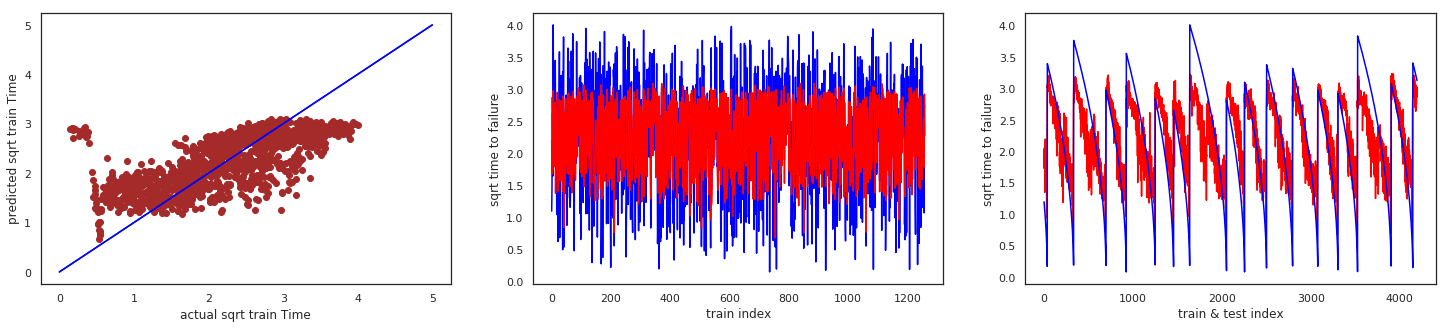

In [31]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

predictions =  gs1.predict(X_test_scaled)
full_predictions = gs1.predict(X_scaled)
print('mean_absolute_error_sqrtTime:', mean_absolute_error(y_test, predictions))
print('r2_score_sqrtTime:', r2_score(y_test, predictions))

fig, axis = plt.subplots(1, 3, figsize=(25,5))
ax1, ax2, ax3 = axis
ax1.set_xlabel('actual sqrt train Time')
ax1.set_ylabel('predicted sqrt train Time')
ax2.set_xlabel('train index')
ax2.set_ylabel('sqrt time to failure')
ax3.set_xlabel('train & test index')
ax3.set_ylabel('sqrt time to failure')
ax1.scatter(y_test.values, predictions, color='brown')
ax1.plot([(0, 0), (5, 5)], [(0, 0), (5, 5)], color='blue')
ax2.plot(y_test.values, color='blue')
ax2.plot(predictions, color='red')
ax3.plot(full_predictions, color='red')
ax3.plot(Y, color='blue')


mean_absolute_error: 2.0322193397002044
r2_score: 0.4953230388182709


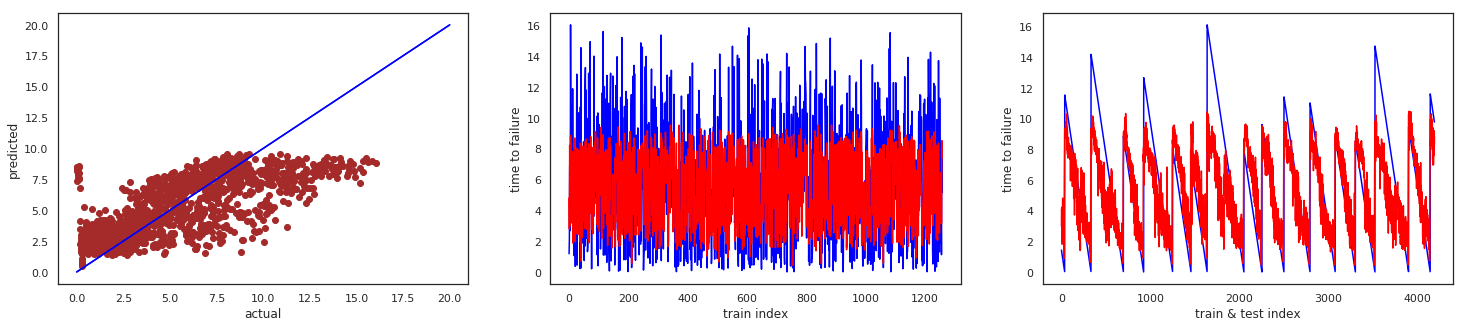

In [32]:
y_predict = np.square(predictions)
y_test_nolog = np.square(y_test)
y_nolog = np.square(Y)
y_nolog_predict = np.square(full_predictions)
print('mean_absolute_error:', mean_absolute_error(y_test_nolog, y_predict))
print('r2_score:', r2_score(y_test_nolog, y_predict))

fig, axis = plt.subplots(1, 3, figsize=(25,5))
ax1, ax2, ax3 = axis
ax1.set_xlabel('actual')
ax1.set_ylabel('predicted')
ax2.set_xlabel('train index')
ax2.set_ylabel('time to failure')
ax3.set_xlabel('train & test index')
ax3.set_ylabel('time to failure')
ax1.scatter(y_test_nolog.values, y_predict, color='brown')
ax1.plot([(0, 0), (20, 20)], [(0, 0), (20, 20)], color='blue')
ax2.plot(y_test_nolog.values, color='blue')
ax2.plot(y_predict, color='red')
ax3.plot(y_nolog, color='blue')
ax3.plot(y_nolog_predict, color='red')

In [33]:
import scipy.stats as st
from xgboost.sklearn import XGBRegressor

one_to_left = st.beta(10, 1)  
from_zero_positive = st.expon(0, 50)

params = {  
    #"n_estimators": st.randint(10000, 20000),
    "max_depth": st.randint(3, 40),
    "learning_rate": st.uniform(0.01, 0.4),
    "colsample_bytree": one_to_left,
    "subsample": one_to_left,
    "gamma": st.uniform(0, 10),
    'reg_alpha': from_zero_positive,
    "min_child_weight": from_zero_positive,
}
xgbreg = XGBRegressor(nthreads=-1, n_estimators=1000)  
gs2 = RandomizedSearchCV(xgbreg, params)  
gs2.fit(X_train_scaled, y_train.values.ravel())  
gs2.best_params_

{'colsample_bytree': 0.9059046706163597,
 'gamma': 4.395361343977617,
 'learning_rate': 0.22367318773362826,
 'max_depth': 21,
 'min_child_weight': 69.30113404571125,
 'reg_alpha': 7.681525516492065,
 'subsample': 0.8919123509453631}

mean_absolute_error_sqrtTime: 0.47625197584994544
r2_score_sqrtTime: 0.47744526043812685


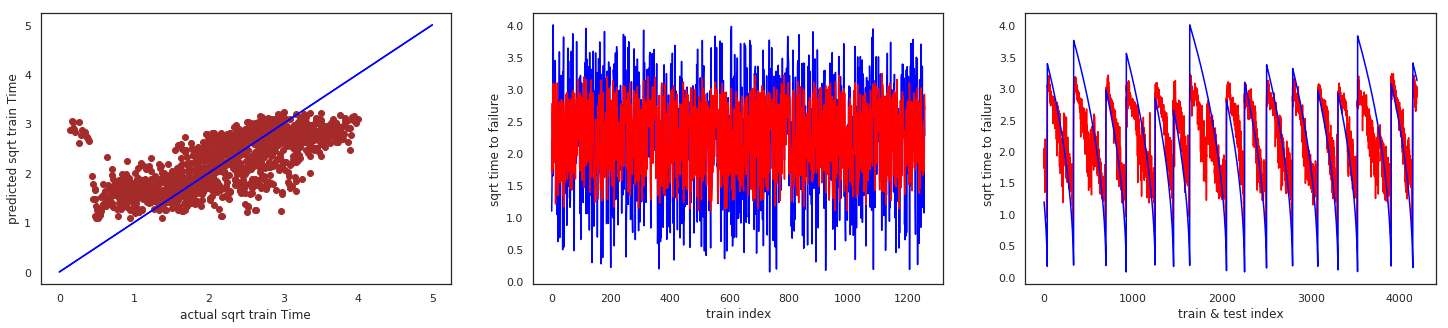

In [34]:
predictions =  gs2.predict(X_test_scaled)
full_predictions = gs1.predict(X_scaled)
print('mean_absolute_error_sqrtTime:', mean_absolute_error(y_test, predictions))
print('r2_score_sqrtTime:', r2_score(y_test, predictions))

fig, axis = plt.subplots(1, 3, figsize=(25,5))
ax1, ax2, ax3 = axis
ax1.set_xlabel('actual sqrt train Time')
ax1.set_ylabel('predicted sqrt train Time')
ax2.set_xlabel('train index')
ax2.set_ylabel('sqrt time to failure')
ax3.set_xlabel('train & test index')
ax3.set_ylabel('sqrt time to failure')
ax1.scatter(y_test.values, predictions, color='brown')
ax1.plot([(0, 0), (5, 5)], [(0, 0), (5, 5)], color='blue')
ax2.plot(y_test.values, color='blue')
ax2.plot(predictions, color='red')
ax3.plot(full_predictions, color='red')
ax3.plot(Y, color='blue')

mean_absolute_error: 2.0634676560951557
r2_score: 0.48347777795889124


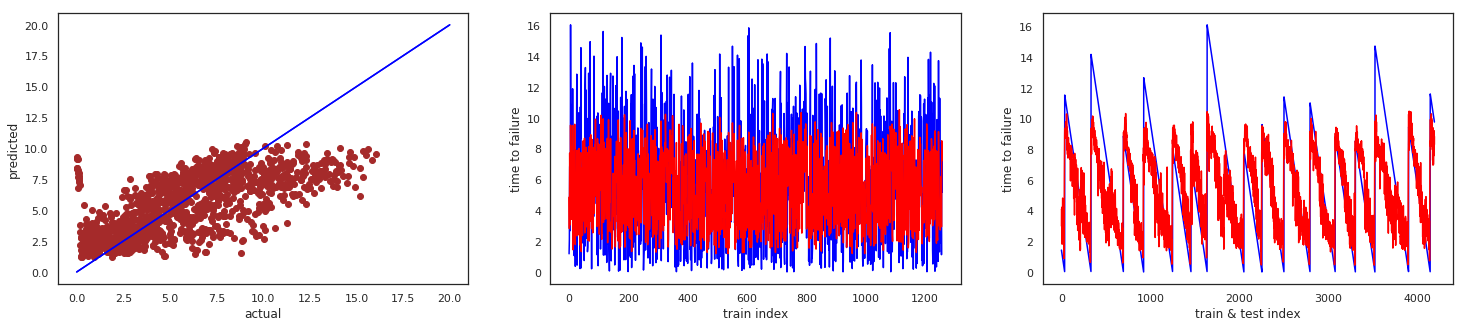

In [35]:
y_predict = np.square(predictions)
y_test_nolog = np.square(y_test)
y_nolog = np.square(Y)
y_nolog_predict = np.square(full_predictions)
print('mean_absolute_error:', mean_absolute_error(y_test_nolog, y_predict))
print('r2_score:', r2_score(y_test_nolog, y_predict))

fig, axis = plt.subplots(1, 3, figsize=(25,5))
ax1, ax2, ax3 = axis
ax1.set_xlabel('actual')
ax1.set_ylabel('predicted')
ax2.set_xlabel('train index')
ax2.set_ylabel('time to failure')
ax3.set_xlabel('train & test index')
ax3.set_ylabel('time to failure')
ax1.scatter(y_test_nolog.values, y_predict, color='brown')
ax1.plot([(0, 0), (20, 20)], [(0, 0), (20, 20)], color='blue')
ax2.plot(y_test_nolog.values, color='blue')
ax2.plot(y_predict, color='red')
ax3.plot(y_nolog, color='blue')
ax3.plot(y_nolog_predict, color='red')

In [36]:
from sklearn.tree import DecisionTreeRegressor

grid = {
    'max_depth': [4, 6, 8, 10, 12],
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_leaf': [2, 4, 12],
    'min_samples_split': st.randint(10,100),
}
#params = grid_search_cv(DecisionTreeRegressor(criterion='mae'),
                        #grid, X_train_scaled, target)
#rf_oof = make_predictions(DecisionTreeRegressor(splitter='random', **params),
                         # X_train_scaled, target)
rfr = DecisionTreeRegressor(criterion='mae')
gs3 = RandomizedSearchCV(rfr, param_distributions = grid)  
gs3.fit(X_train_scaled, y_train.values.ravel())  
gs3.best_params_      

{'max_depth': 4,
 'max_features': 'sqrt',
 'min_samples_leaf': 12,
 'min_samples_split': 70}

mean_absolute_error_sqrtTime: 0.4780754349457072
r2_score_sqrtTime: 0.4632709698942775


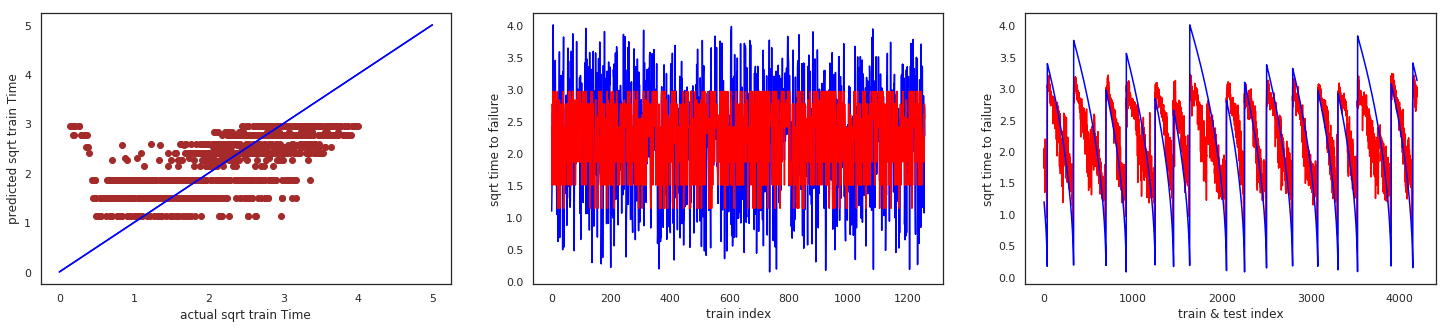

In [37]:
predictions =  gs3.predict(X_test_scaled)
full_predictions = gs1.predict(X_scaled)
print('mean_absolute_error_sqrtTime:', mean_absolute_error(y_test, predictions))
print('r2_score_sqrtTime:', r2_score(y_test, predictions))

fig, axis = plt.subplots(1, 3, figsize=(25,5))
ax1, ax2, ax3 = axis
ax1.set_xlabel('actual sqrt train Time')
ax1.set_ylabel('predicted sqrt train Time')
ax2.set_xlabel('train index')
ax2.set_ylabel('sqrt time to failure')
ax3.set_xlabel('train & test index')
ax3.set_ylabel('sqrt time to failure')
ax1.scatter(y_test.values, predictions, color='brown')
ax1.plot([(0, 0), (5, 5)], [(0, 0), (5, 5)], color='blue')
ax2.plot(y_test.values, color='blue')
ax2.plot(predictions, color='red')
ax3.plot(full_predictions, color='red')
ax3.plot(Y, color='blue')

mean_absolute_error: 2.066672622791363
r2_score: 0.4703327918288054


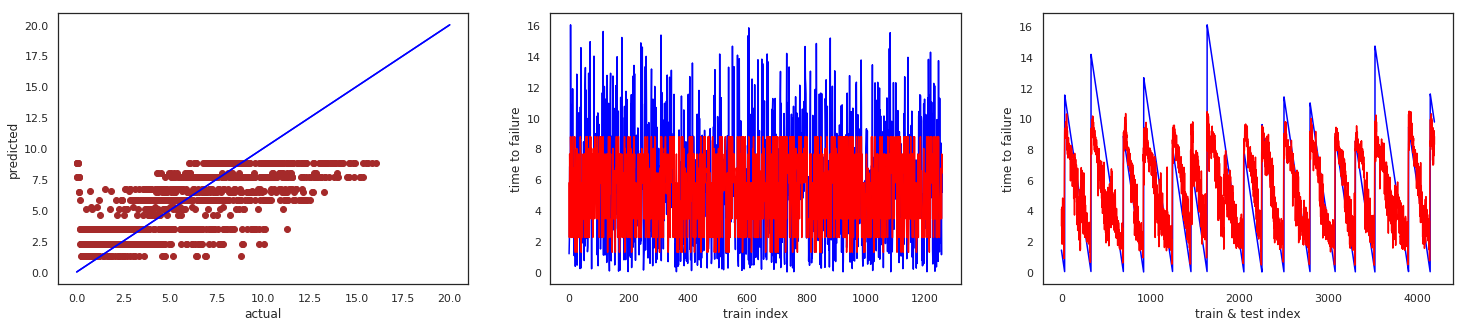

In [38]:
y_predict = np.square(predictions)
y_test_nolog = np.square(y_test)
y_nolog = np.square(Y)
y_nolog_predict = np.square(full_predictions)
print('mean_absolute_error:', mean_absolute_error(y_test_nolog, y_predict))
print('r2_score:', r2_score(y_test_nolog, y_predict))

fig, axis = plt.subplots(1, 3, figsize=(25,5))
ax1, ax2, ax3 = axis
ax1.set_xlabel('actual')
ax1.set_ylabel('predicted')
ax2.set_xlabel('train index')
ax2.set_ylabel('time to failure')
ax3.set_xlabel('train & test index')
ax3.set_ylabel('time to failure')
ax1.scatter(y_test_nolog.values, y_predict, color='brown')
ax1.plot([(0, 0), (20, 20)], [(0, 0), (20, 20)], color='blue')
ax2.plot(y_test_nolog.values, color='blue')
ax2.plot(y_predict, color='red')
ax3.plot(y_nolog, color='blue')
ax3.plot(y_nolog_predict, color='red')

In [39]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import LinearRegression, Ridge

grid = {
    #'max_depth': [4, 6, 8, 10, 12],
    #'max_features': ['auto', 'sqrt', 'log2'],
    #'min_samples_leaf': [2, 4, 12],
    #'min_samples_split': [4,8,12,16,20, 30, 40, 50, 60],
    "learning_rate": st.uniform(0.01, 0.4),
    'loss' : ["square"],
    #'n_estimators' : st.randint(10000, 20000)
}
#params = grid_search_cv(AdaBoostRegressor(),
                        #grid, X_train_scaled, target)
#rf_oof = make_predictions(AdaBoostRegressor(**params),
                          #X_train_scaled, target)
base = Ridge(alpha=1) 
rfr = AdaBoostRegressor(n_estimators = 500, base_estimator=base)
gs4 = RandomizedSearchCV(rfr, param_distributions = grid)  
gs4.fit(X_train_scaled, y_train.values.ravel())  
gs4.best_params_      

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'learning_rate': 0.029576337407856847, 'loss': 'square'}

mean_absolute_error_sqrtTime: 0.7781737708135373
r2_score_sqrtTime: -0.42840706573438236


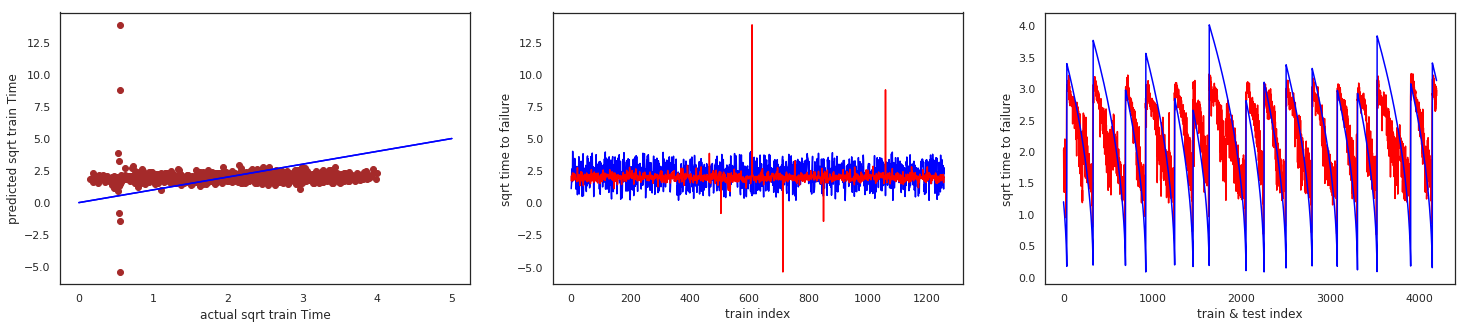

In [40]:
predictions =  gs4.predict(X_test_scaled)
full_predictions = gs1.predict(X_scaled)
print('mean_absolute_error_sqrtTime:', mean_absolute_error(y_test, predictions))
print('r2_score_sqrtTime:', r2_score(y_test, predictions))

fig, axis = plt.subplots(1, 3, figsize=(25,5))
ax1, ax2, ax3 = axis
ax1.set_xlabel('actual sqrt train Time')
ax1.set_ylabel('predicted sqrt train Time')
ax2.set_xlabel('train index')
ax2.set_ylabel('sqrt time to failure')
ax3.set_xlabel('train & test index')
ax3.set_ylabel('sqrt time to failure')
ax1.scatter(y_test.values, predictions, color='brown')
ax1.plot([(0, 0), (5, 5)], [(0, 0), (5, 5)], color='blue')
ax2.plot(y_test.values, color='blue')
ax2.plot(predictions, color='red')
ax3.plot(full_predictions, color='red')
ax3.plot(Y, color='blue')

mean_absolute_error: 3.5253582286243916
r2_score: -2.758374394611597


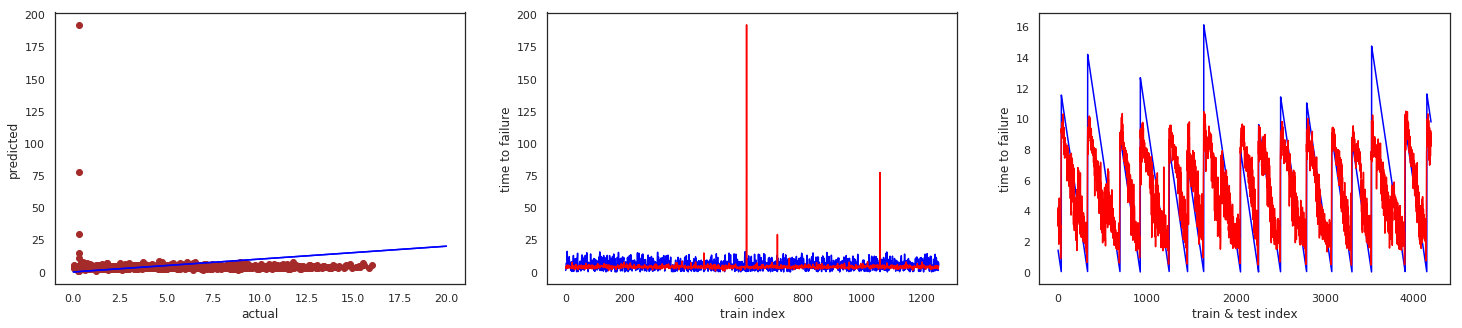

In [41]:
y_predict = np.square(predictions)
y_test_nolog = np.square(y_test)
y_nolog = np.square(Y)
y_nolog_predict = np.square(full_predictions)
print('mean_absolute_error:', mean_absolute_error(y_test_nolog, y_predict))
print('r2_score:', r2_score(y_test_nolog, y_predict))

fig, axis = plt.subplots(1, 3, figsize=(25,5))
ax1, ax2, ax3 = axis
ax1.set_xlabel('actual')
ax1.set_ylabel('predicted')
ax2.set_xlabel('train index')
ax2.set_ylabel('time to failure')
ax3.set_xlabel('train & test index')
ax3.set_ylabel('time to failure')
ax1.scatter(y_test_nolog.values, y_predict, color='brown')
ax1.plot([(0, 0), (20, 20)], [(0, 0), (20, 20)], color='blue')
ax2.plot(y_test_nolog.values, color='blue')
ax2.plot(y_predict, color='red')
ax3.plot(y_nolog, color='blue')
ax3.plot(y_nolog_predict, color='red')

The size of data is increasing day by day and it is becoming difficult for traditional data science algorithms to give faster results. Light GBM is prefixed as ‘Light’ because of its high speed. Light GBM can handle the large size of data and takes lower memory to run. Another reason of why Light GBM is popular is because it focuses on accuracy of results. LGBM also supports GPU learning and thus data scientists are widely using LGBM for data science application development. [https://medium.com/@pushkarmandot/https-medium-com-pushkarmandot-what-is-lightgbm-how-to-implement-it-how-to-fine-tune-the-parameters-60347819b7fc]

In [42]:
import lightgbm as lgb

grid = {
    'learning_rate': [0.1, 0.05, 0.01, 0.005],
    'num_leaves': list(range(8, 92, 4)),
    'max_depth': [3, 4, 5, 6, 8, 12, 16, -1],
    'feature_fraction': [0.8, 0.85, 0.9, 0.95, 1],
    'subsample': [0.8, 0.85, 0.9, 0.95, 1],
    'lambda_l1': [0, 0.1, 0.2, 0.4, 0.6, 0.9],
    'lambda_l2': [0, 0.1, 0.2, 0.4, 0.6, 0.9],
    'min_data_in_leaf': [10, 20, 40, 60, 100],
    'min_gain_to_split': [0, 0.001, 0.01, 0.1],
    'random_seed': st.randint(10, 100),
    }
#params = grid_search_cv(RandomForestRegressor(criterion='mse', n_estimators=50),
                        #grid, X_train_scaled, target)
rfr = lgb.LGBMRegressor(n_estimators=10000)
gs5 = RandomizedSearchCV(rfr, param_distributions = grid)  
gs5.fit(X_train_scaled, y_train.values.ravel())  
gs5.best_params_    
#rf_oof = make_predictions(RandomForestRegressor(**params),
                          #X_train_scaled, target)

{'feature_fraction': 1,
 'lambda_l1': 0.6,
 'lambda_l2': 0.4,
 'learning_rate': 0.05,
 'max_depth': 8,
 'min_data_in_leaf': 10,
 'min_gain_to_split': 0.01,
 'num_leaves': 44,
 'random_seed': 13,
 'subsample': 0.9}

mean_absolute_error_sqrtTime: 0.4773896696840274
r2_score_sqrtTime: 0.4638739691725142


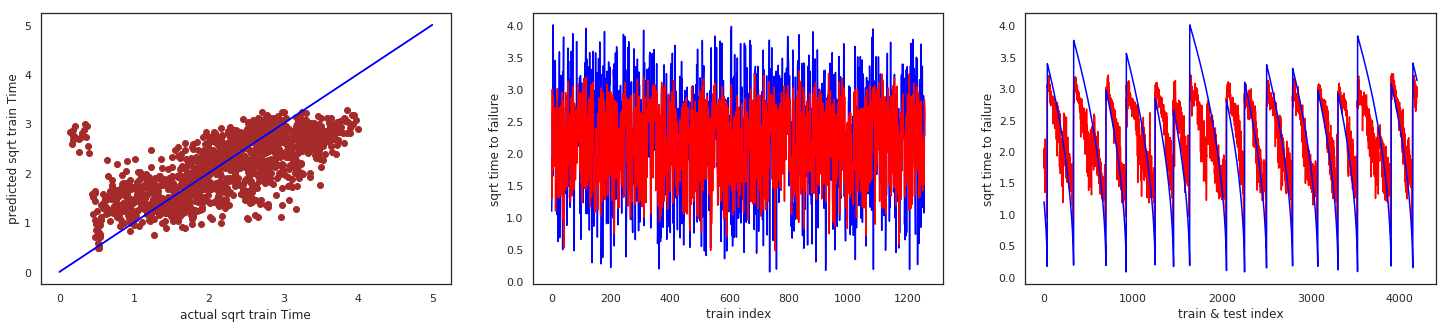

In [43]:
predictions =  gs5.predict(X_test_scaled)
full_predictions = gs1.predict(X_scaled)
print('mean_absolute_error_sqrtTime:', mean_absolute_error(y_test, predictions))
print('r2_score_sqrtTime:', r2_score(y_test, predictions))

fig, axis = plt.subplots(1, 3, figsize=(25,5))
ax1, ax2, ax3 = axis
ax1.set_xlabel('actual sqrt train Time')
ax1.set_ylabel('predicted sqrt train Time')
ax2.set_xlabel('train index')
ax2.set_ylabel('sqrt time to failure')
ax3.set_xlabel('train & test index')
ax3.set_ylabel('sqrt time to failure')
ax1.scatter(y_test.values, predictions, color='brown')
ax1.plot([(0, 0), (5, 5)], [(0, 0), (5, 5)], color='blue')
ax2.plot(y_test.values, color='blue')
ax2.plot(predictions, color='red')
ax3.plot(full_predictions, color='red')
ax3.plot(Y, color='blue')

mean_absolute_error: 2.089058482904736
r2_score: 0.43881088754719744


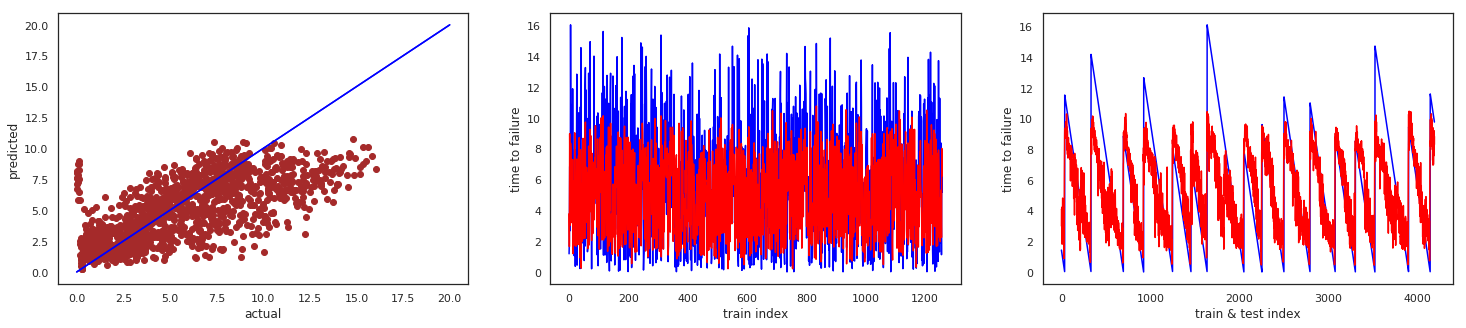

In [44]:
y_predict = np.square(predictions)
y_test_nolog = np.square(y_test)
y_nolog = np.square(Y)
y_nolog_predict = np.square(full_predictions)
print('mean_absolute_error:', mean_absolute_error(y_test_nolog, y_predict))
print('r2_score:', r2_score(y_test_nolog, y_predict))

fig, axis = plt.subplots(1, 3, figsize=(25,5))
ax1, ax2, ax3 = axis
ax1.set_xlabel('actual')
ax1.set_ylabel('predicted')
ax2.set_xlabel('train index')
ax2.set_ylabel('time to failure')
ax3.set_xlabel('train & test index')
ax3.set_ylabel('time to failure')
ax1.scatter(y_test_nolog.values, y_predict, color='brown')
ax1.plot([(0, 0), (20, 20)], [(0, 0), (20, 20)], color='blue')
ax2.plot(y_test_nolog.values, color='blue')
ax2.plot(y_predict, color='red')
ax3.plot(y_nolog, color='blue')
ax3.plot(y_nolog_predict, color='red')

In [45]:
from sklearn import ensemble
from sklearn.ensemble import ExtraTreesRegressor

grid = {
    'max_depth': [6,11,15,20],
    'max_features': ['auto'],
    'min_samples_leaf': [10,16,20,40],
    'min_samples_split': [50,98,150,200],
    'n_estimators': [100, 200, 495,1000],
    'min_weight_fraction_leaf':  st.uniform(0, 0.5)
    }

etr = ExtraTreesRegressor(criterion='mae')
gs6 = RandomizedSearchCV(etr, param_distributions = grid)  
gs6.fit(X_train_scaled, y_train.values.ravel())  
gs6.best_params_ 

{'max_depth': 11,
 'max_features': 'auto',
 'min_samples_leaf': 40,
 'min_samples_split': 200,
 'min_weight_fraction_leaf': 0.010872755116371424,
 'n_estimators': 200}

mean_absolute_error_sqrtTime: 0.4702182296243947
r2_score_sqrtTime: 0.48355993231404804


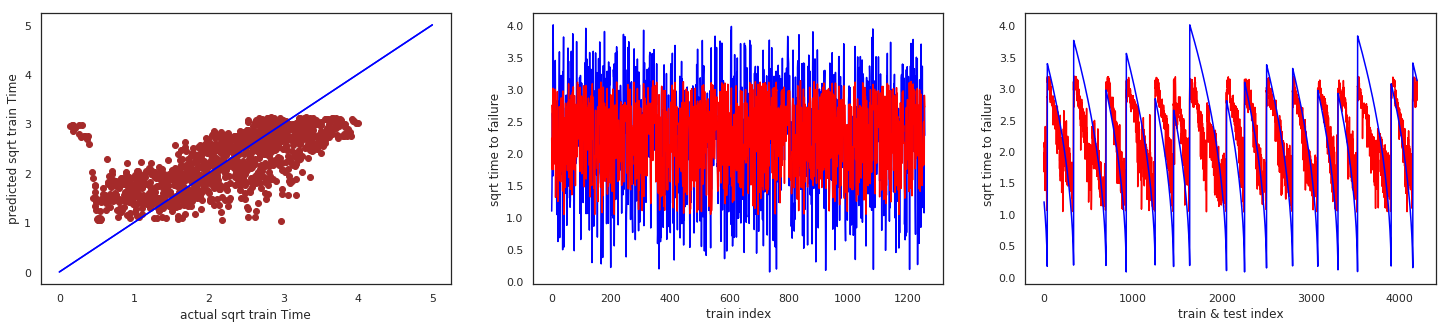

In [46]:
predictions =  gs6.predict(X_test_scaled)
full_predictions = gs6.predict(X_scaled)
print('mean_absolute_error_sqrtTime:', mean_absolute_error(y_test, predictions))
print('r2_score_sqrtTime:', r2_score(y_test, predictions))

fig, axis = plt.subplots(1, 3, figsize=(25,5))
ax1, ax2, ax3 = axis
ax1.set_xlabel('actual sqrt train Time')
ax1.set_ylabel('predicted sqrt train Time')
ax2.set_xlabel('train index')
ax2.set_ylabel('sqrt time to failure')
ax3.set_xlabel('train & test index')
ax3.set_ylabel('sqrt time to failure')
ax1.scatter(y_test.values, predictions, color='brown')
ax1.plot([(0, 0), (5, 5)], [(0, 0), (5, 5)], color='blue')
ax2.plot(y_test.values, color='blue')
ax2.plot(predictions, color='red')
ax3.plot(full_predictions, color='red')
ax3.plot(Y, color='blue')

mean_absolute_error: 2.0338440361453003
r2_score: 0.4950754543622904


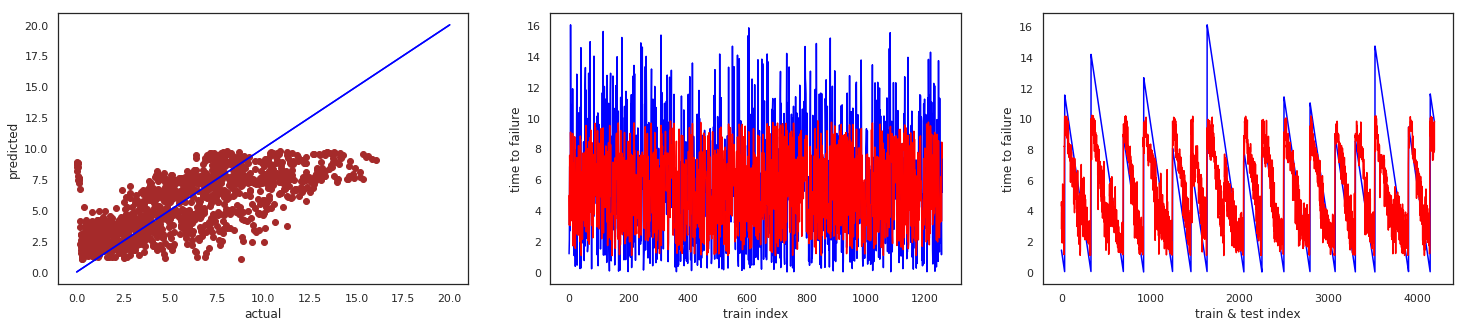

In [47]:
y_predict = np.square(predictions)
y_test_nolog = np.square(y_test)
y_nolog = np.square(Y)
y_nolog_predict = np.square(full_predictions)
print('mean_absolute_error:', mean_absolute_error(y_test_nolog, y_predict))
print('r2_score:', r2_score(y_test_nolog, y_predict))

fig, axis = plt.subplots(1, 3, figsize=(25,5))
ax1, ax2, ax3 = axis
ax1.set_xlabel('actual')
ax1.set_ylabel('predicted')
ax2.set_xlabel('train index')
ax2.set_ylabel('time to failure')
ax3.set_xlabel('train & test index')
ax3.set_ylabel('time to failure')
ax1.scatter(y_test_nolog.values, y_predict, color='brown')
ax1.plot([(0, 0), (20, 20)], [(0, 0), (20, 20)], color='blue')
ax2.plot(y_test_nolog.values, color='blue')
ax2.plot(y_predict, color='red')
ax3.plot(y_nolog, color='blue')
ax3.plot(y_nolog_predict, color='red')

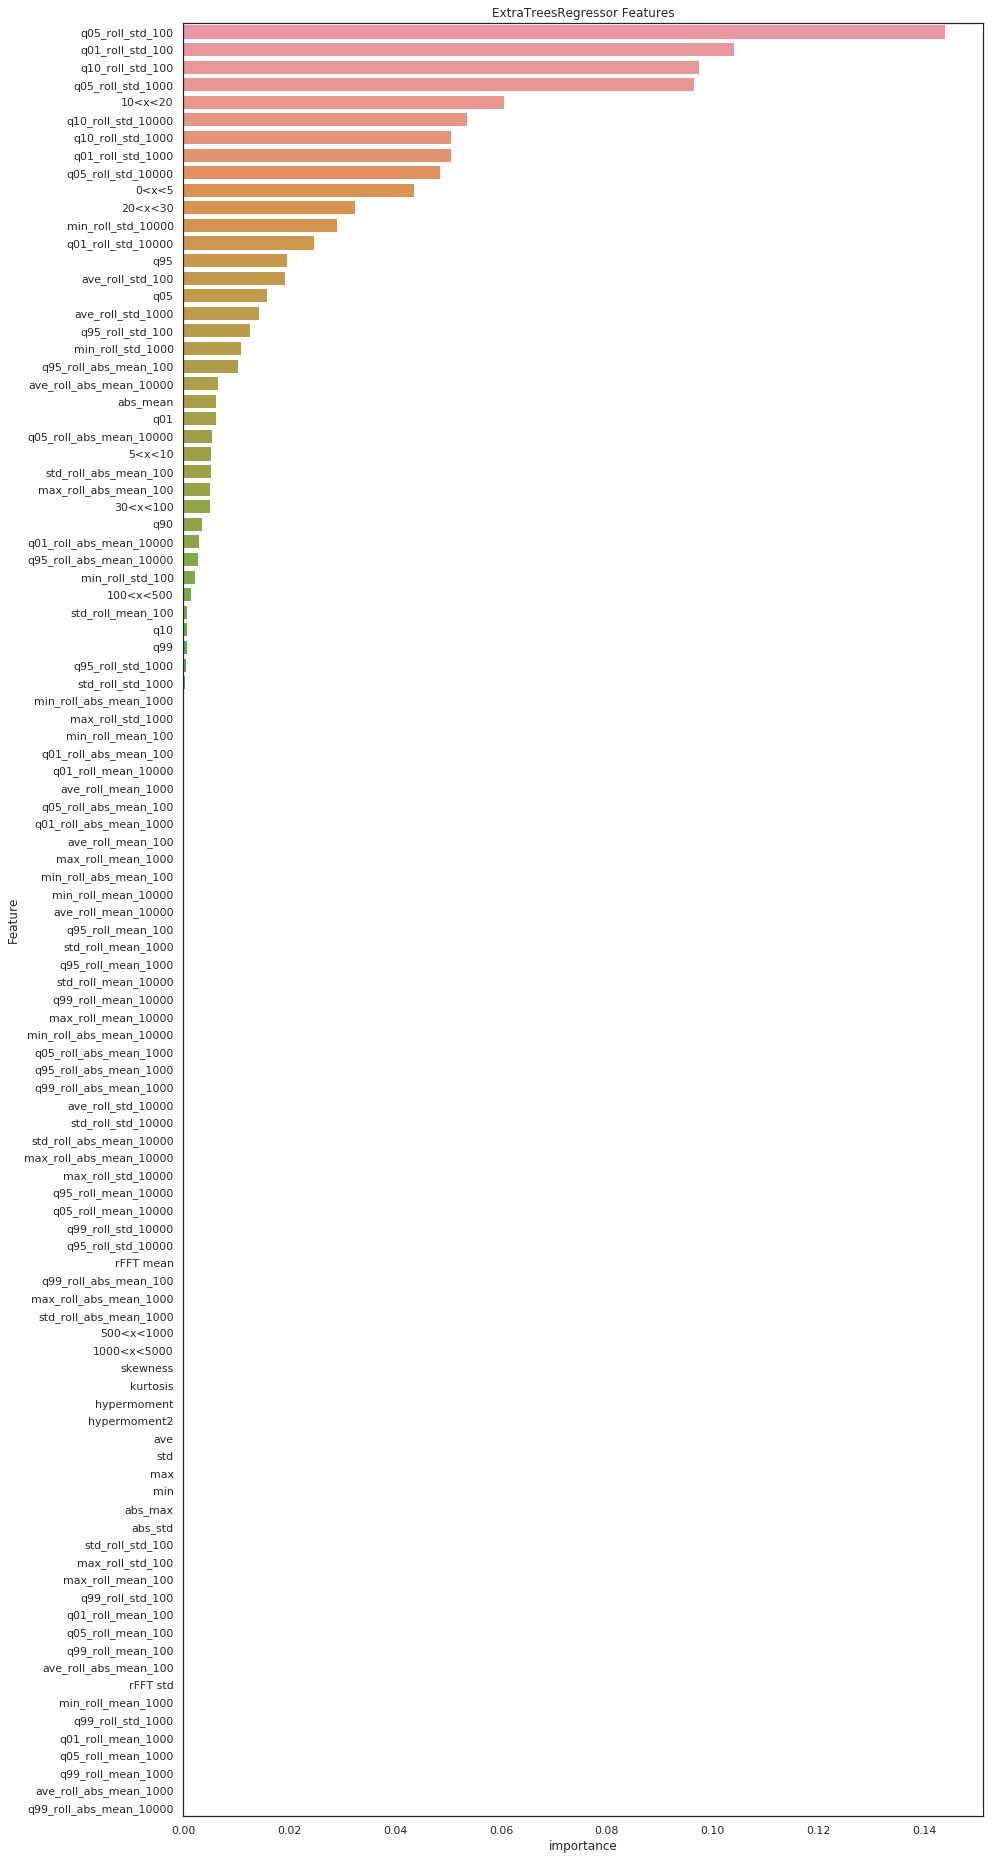

In [48]:
#The values of this array sum to 1, unless all trees are single node trees consisting of only the root node, 
#in which case it will be an array of zeros.
model = ExtraTreesRegressor(criterion='mse',max_depth=20,max_features='auto',min_samples_leaf=20,min_samples_split=50,
                            min_weight_fraction_leaf=0.2677238296443694,n_estimators=200 )
model.fit(X_train_scaled, y_train.values.ravel())

fold_importance_df = pd.DataFrame()
feature_importance_df = pd.DataFrame()
fold_importance_df["Feature"] = X_train.columns
fold_importance_df["importance"] = model.feature_importances_[:len(X_train.columns)]
feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:200].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,26))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('ExtraTreesRegressor Features')
plt.tight_layout()
plt.savefig('ExtraTreesRegressor_importances.png')

### PCA

In [49]:
from sklearn.decomposition import PCA

pca = PCA(n_components=10)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2', 'principal component 3', 'principal component 4', 
                          'principal component 5', 'principal component 6', 'principal component 7', 'principal component 8',
                          'principal component 9','principal component 10'])
principalDf.head()

,principal component 1,principal component 2,principal component 3,principal component 4,principal component 5,principal component 6,principal component 7,principal component 8,principal component 9,principal component 10
0,-2.53356954e+15,1.06371829e+10,-3.94110528e+07,-301.26006252,4059.24811993,6241.72689654,-649.27273395,661.57980875,-76.45596226,-9.96013414
1,-2.53356677e+15,1.06341669e+10,-3.92444431e+07,-184.58504312,4237.49695048,3465.15038426,-202.04429369,164.50058618,-95.71839742,-36.16459813
2,-2.53356915e+15,1.06362590e+10,-3.93497950e+07,-210.98975789,8924.72589449,4796.15968318,-362.99900004,162.00260621,337.56243306,29.98501270
3,-2.53356362e+15,1.06307482e+10,-3.91621091e+07,-44.81544647,5896.75071102,6105.97226618,-210.48884274,330.16482674,15.28070255,-89.62754513
4,-2.53356825e+15,1.06363845e+10,-3.92769617e+07,-268.17298061,6097.13284639,5536.36927968,-41.52378890,99.55922017,314.77635546,-134.19991776


In [50]:
pca.explained_variance_ratio_

array([9.99999992e-01, 8.32568853e-09, 7.22571964e-16, 2.01652734e-24,
       2.62252033e-26, 1.09229696e-26, 2.83603423e-28, 5.76944284e-29,
       1.49586313e-29, 4.03683593e-30])

In [51]:
X_PCA_train_final = principalDf.values

In [52]:
from sklearn.model_selection import train_test_split
X_PCA_train, X_PCA_test, y_train, y_test = train_test_split(X_PCA_train_final,Y,test_size=.3,random_state=100, shuffle=True)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
    
scl_obj.fit(X_PCA_train)
X_PCA_train = scl_obj.transform(X_PCA_train)
scl_obj.fit(X_PCA_test)
X_PCA_test = scl_obj.transform(X_PCA_test)
scl_obj.fit(X_PCA_train_final)
X_PCA = scl_obj.transform(X_PCA_train_final)

(2935, 102)
(1259, 102)
(2935, 1)
(1259, 1)


In [53]:
grid = {
    'max_depth': [8, 10],
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_leaf': [2, 4, 12],
    'min_samples_split': [2, 6, 12],
    #'n_estimators' : st.randint(10000, 20000),
}
#params = grid_search_cv(RandomForestRegressor(criterion='mse', n_estimators=50),
                        #grid, X_train_scaled, target)
rfr = RandomForestRegressor(criterion='mse',n_estimators=1000)
gs7 = RandomizedSearchCV(rfr, param_distributions = grid)  
gs7.fit(X_PCA_train, y_train.values.ravel())  
gs7.best_params_   
#rf_oof = make_predictions(RandomForestRegressor(**params),
                          #X_train_scaled, target)

{'min_samples_split': 6,
 'min_samples_leaf': 12,
 'max_features': 'auto',
 'max_depth': 8}

mean_absolute_error_sqrtTime: 0.4920809566612686
r2_score_sqrtTime: 0.4363011147955632


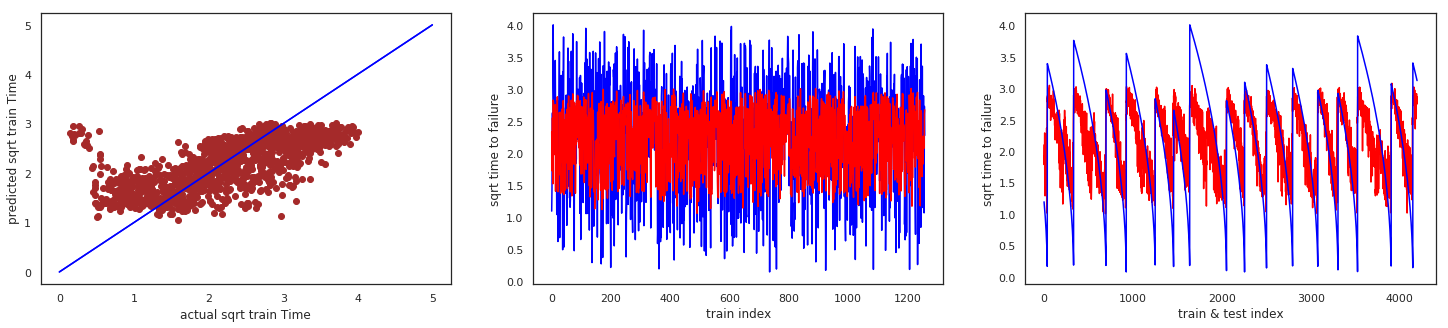

In [54]:
predictions =  gs7.predict(X_PCA_test)
full_predictions = gs7.predict(X_PCA)
print('mean_absolute_error_sqrtTime:', mean_absolute_error(y_test, predictions))
print('r2_score_sqrtTime:', r2_score(y_test, predictions))

fig, axis = plt.subplots(1, 3, figsize=(25,5))
ax1, ax2, ax3 = axis
ax1.set_xlabel('actual sqrt train Time')
ax1.set_ylabel('predicted sqrt train Time')
ax2.set_xlabel('train index')
ax2.set_ylabel('sqrt time to failure')
ax3.set_xlabel('train & test index')
ax3.set_ylabel('sqrt time to failure')
ax1.scatter(y_test.values, predictions, color='brown')
ax1.plot([(0, 0), (5, 5)], [(0, 0), (5, 5)], color='blue')
ax2.plot(y_test.values, color='blue')
ax2.plot(predictions, color='red')
ax3.plot(full_predictions, color='red')
ax3.plot(Y, color='blue')

mean_absolute_error: 2.131190589264179
r2_score: 0.42831312458842175


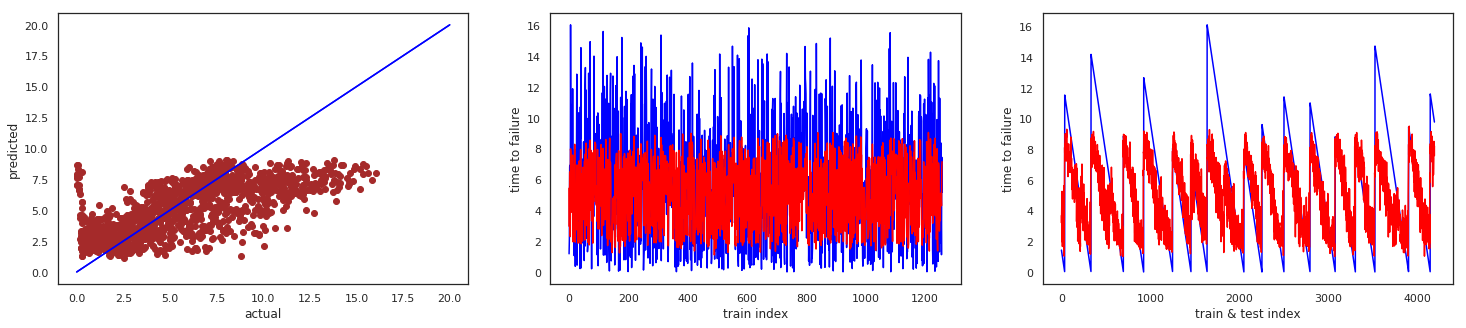

In [55]:
y_predict = np.square(predictions)
y_test_nolog = np.square(y_test)
y_nolog = np.square(Y)
y_nolog_predict = np.square(full_predictions)
print('mean_absolute_error:', mean_absolute_error(y_test_nolog, y_predict))
print('r2_score:', r2_score(y_test_nolog, y_predict))

fig, axis = plt.subplots(1, 3, figsize=(25,5))
ax1, ax2, ax3 = axis
ax1.set_xlabel('actual')
ax1.set_ylabel('predicted')
ax2.set_xlabel('train index')
ax2.set_ylabel('time to failure')
ax3.set_xlabel('train & test index')
ax3.set_ylabel('time to failure')
ax1.scatter(y_test_nolog.values, y_predict, color='brown')
ax1.plot([(0, 0), (20, 20)], [(0, 0), (20, 20)], color='blue')
ax2.plot(y_test_nolog.values, color='blue')
ax2.plot(y_predict, color='red')
ax3.plot(y_nolog, color='blue')
ax3.plot(y_nolog_predict, color='red')

In [56]:
import scipy.stats as st
from xgboost.sklearn import XGBRegressor

one_to_left = st.beta(10, 1)  
from_zero_positive = st.expon(0, 50)

params = {  
    #"n_estimators": st.randint(10000, 20000),
    "max_depth": st.randint(3, 40),
    "learning_rate": st.uniform(0.01, 0.4),
    "colsample_bytree": one_to_left,
    "subsample": one_to_left,
    "gamma": st.uniform(0, 10),
    'reg_alpha': from_zero_positive,
    "min_child_weight": from_zero_positive,
}

xgbreg = XGBRegressor(nthreads=-1,n_estimators=500, cv=5)  
gs8 = RandomizedSearchCV(xgbreg, params)  
gs8.fit(X_PCA_train, y_train.values.ravel())  
gs8.best_params_

{'colsample_bytree': 0.9733183508514934,
 'gamma': 2.9208616322214906,
 'learning_rate': 0.06499245187801281,
 'max_depth': 23,
 'min_child_weight': 36.2847114711098,
 'reg_alpha': 5.8208102580024494,
 'subsample': 0.9573901978319634}

mean_absolute_error_sqrtTime: 0.49493052814573024
r2_score_sqrtTime: 0.4270013142794091


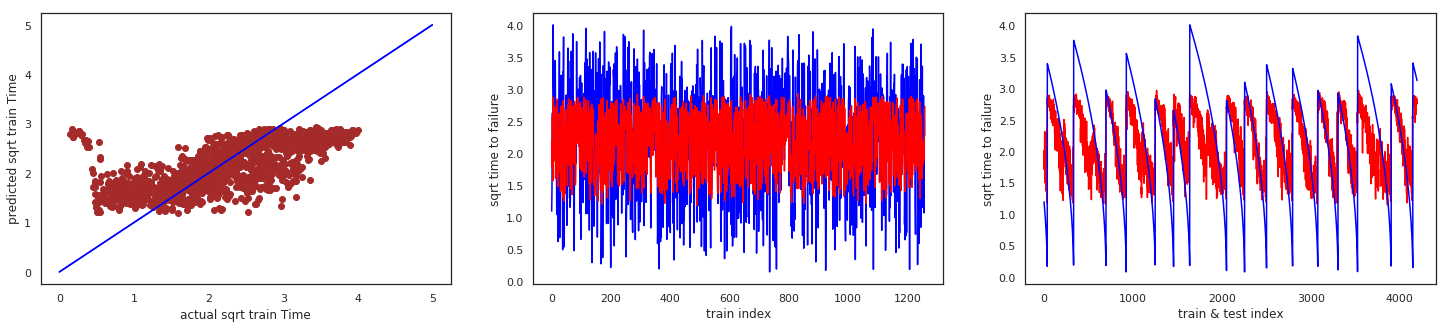

In [57]:
predictions =  gs8.predict(X_PCA_test)
full_predictions = gs8.predict(X_PCA)
print('mean_absolute_error_sqrtTime:', mean_absolute_error(y_test, predictions))
print('r2_score_sqrtTime:', r2_score(y_test, predictions))

fig, axis = plt.subplots(1, 3, figsize=(25,5))
ax1, ax2, ax3 = axis
ax1.set_xlabel('actual sqrt train Time')
ax1.set_ylabel('predicted sqrt train Time')
ax2.set_xlabel('train index')
ax2.set_ylabel('sqrt time to failure')
ax3.set_xlabel('train & test index')
ax3.set_ylabel('sqrt time to failure')
ax1.scatter(y_test.values, predictions, color='brown')
ax1.plot([(0, 0), (5, 5)], [(0, 0), (5, 5)], color='blue')
ax2.plot(y_test.values, color='blue')
ax2.plot(predictions, color='red')
ax3.plot(full_predictions, color='red')
ax3.plot(Y, color='blue')

mean_absolute_error: 2.14582827179714
r2_score: 0.4097390341780406


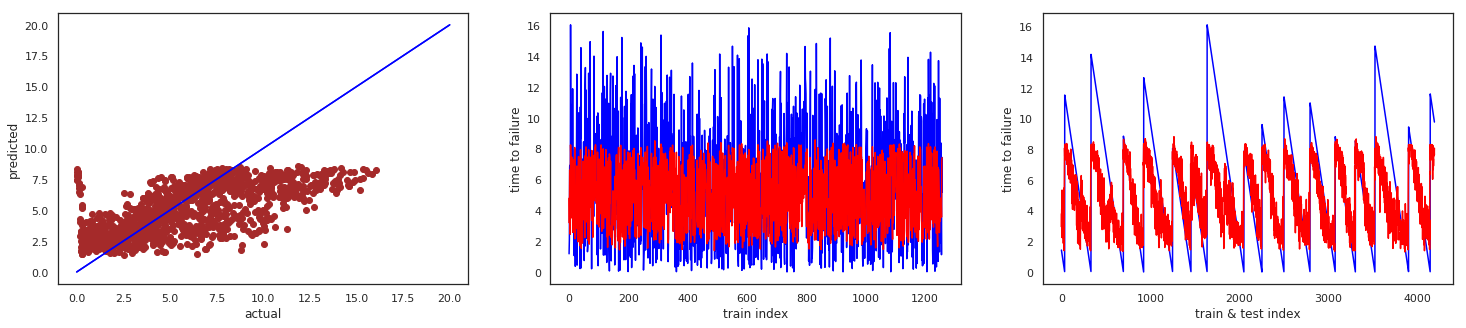

In [58]:
y_predict = np.square(predictions)
y_test_nolog = np.square(y_test)
y_nolog = np.square(Y)
y_nolog_predict = np.square(full_predictions)
print('mean_absolute_error:', mean_absolute_error(y_test_nolog, y_predict))
print('r2_score:', r2_score(y_test_nolog, y_predict))

fig, axis = plt.subplots(1, 3, figsize=(25,5))
ax1, ax2, ax3 = axis
ax1.set_xlabel('actual')
ax1.set_ylabel('predicted')
ax2.set_xlabel('train index')
ax2.set_ylabel('time to failure')
ax3.set_xlabel('train & test index')
ax3.set_ylabel('time to failure')
ax1.scatter(y_test_nolog.values, y_predict, color='brown')
ax1.plot([(0, 0), (20, 20)], [(0, 0), (20, 20)], color='blue')
ax2.plot(y_test_nolog.values, color='blue')
ax2.plot(y_predict, color='red')
ax3.plot(y_nolog, color='blue')
ax3.plot(y_nolog_predict, color='red')

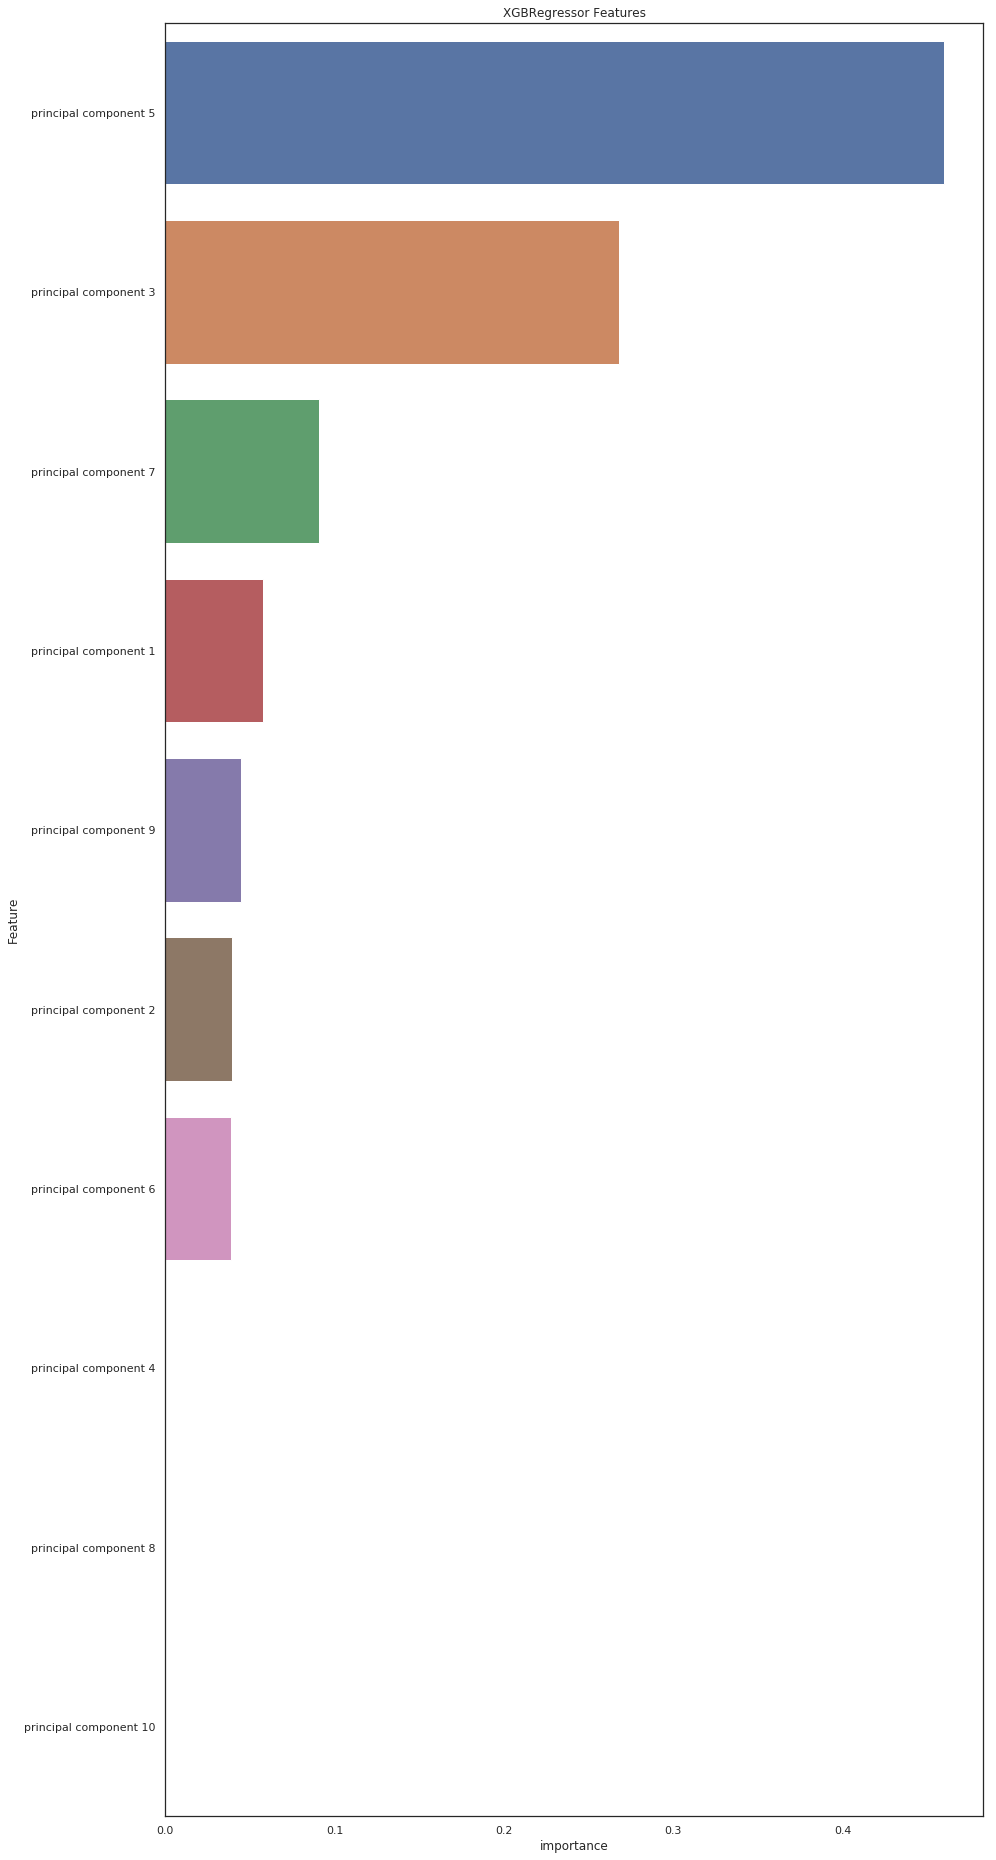

In [59]:
#The values of this array sum to 1, unless all trees are single node trees consisting of only the root node, 
#in which case it will be an array of zeros.
model = XGBRegressor(nthreads=-1,n_estimators=500,colsample_bytree=0.8385749300087559,gamma=4.711994964749211,
                     learning_rate=0.02198803862710416,max_depth=17,min_child_weight=114.35959341213693,
                     reg_alpha=59.19676051250868,subsample=0.9732956894126421)
model.fit(X_PCA_train, y_train)

fold_importance_df = pd.DataFrame()
feature_importance_df = pd.DataFrame()
fold_importance_df["Feature"] = principalDf.columns
fold_importance_df["importance"] = model.feature_importances_[:len(principalDf.columns)]
feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:200].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,26))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('XGBRegressor Features')
plt.tight_layout()
plt.savefig('XGBRegressor_importances.png')

In [60]:
from sklearn.tree import DecisionTreeRegressor

grid = {
    'max_depth': st.randint(4,12),
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_leaf': st.randint(2,12),
    'min_samples_split': st.randint(10,100),
}
#params = grid_search_cv(DecisionTreeRegressor(criterion='mae'),
                        #grid, X_train_scaled, target)
#rf_oof = make_predictions(DecisionTreeRegressor(splitter='random', **params),
                         # X_train_scaled, target)
    
rfr = DecisionTreeRegressor(criterion='mae')
gs9 = RandomizedSearchCV(rfr, param_distributions = grid)  
gs9.fit(X_PCA_train, y_train.values.ravel())  
gs9.best_params_ 

{'max_depth': 5,
 'max_features': 'auto',
 'min_samples_leaf': 8,
 'min_samples_split': 68}

mean_absolute_error_sqrtTime: 0.502974901860247
r2_score_sqrtTime: 0.40548398796543994


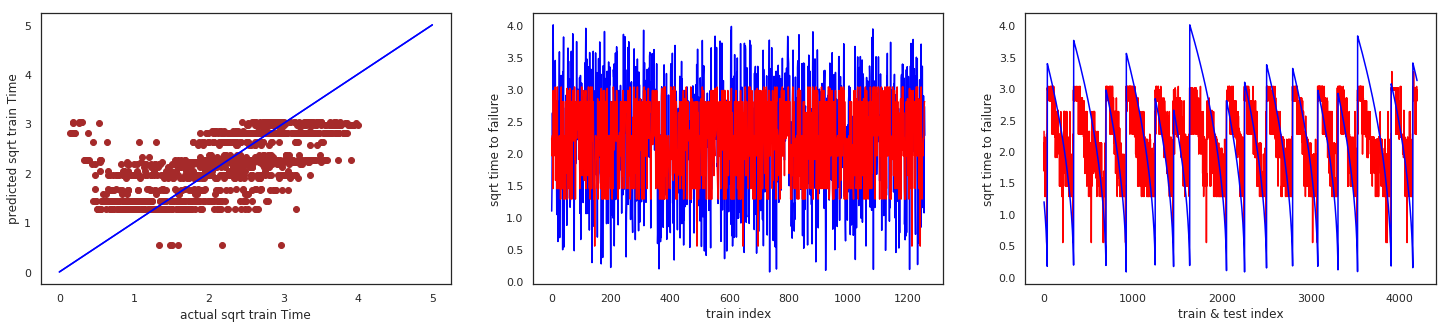

In [61]:
predictions =  gs9.predict(X_PCA_test)
full_predictions = gs9.predict(X_PCA)
print('mean_absolute_error_sqrtTime:', mean_absolute_error(y_test, predictions))
print('r2_score_sqrtTime:', r2_score(y_test, predictions))

fig, axis = plt.subplots(1, 3, figsize=(25,5))
ax1, ax2, ax3 = axis
ax1.set_xlabel('actual sqrt train Time')
ax1.set_ylabel('predicted sqrt train Time')
ax2.set_xlabel('train index')
ax2.set_ylabel('sqrt time to failure')
ax3.set_xlabel('train & test index')
ax3.set_ylabel('sqrt time to failure')
ax1.scatter(y_test.values, predictions, color='brown')
ax1.plot([(0, 0), (5, 5)], [(0, 0), (5, 5)], color='blue')
ax2.plot(y_test.values, color='blue')
ax2.plot(predictions, color='red')
ax3.plot(full_predictions, color='red')
ax3.plot(Y, color='blue')

mean_absolute_error: 2.1689159872905943
r2_score: 0.416981023302621


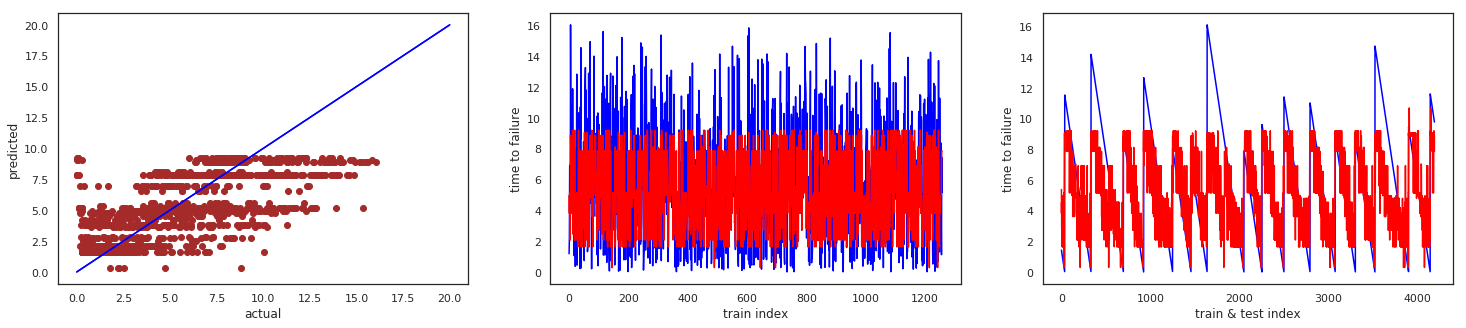

In [62]:
y_predict = np.square(predictions)
y_test_nolog = np.square(y_test)
y_nolog = np.square(Y)
y_nolog_predict = np.square(full_predictions)
print('mean_absolute_error:', mean_absolute_error(y_test_nolog, y_predict))
print('r2_score:', r2_score(y_test_nolog, y_predict))

fig, axis = plt.subplots(1, 3, figsize=(25,5))
ax1, ax2, ax3 = axis
ax1.set_xlabel('actual')
ax1.set_ylabel('predicted')
ax2.set_xlabel('train index')
ax2.set_ylabel('time to failure')
ax3.set_xlabel('train & test index')
ax3.set_ylabel('time to failure')
ax1.scatter(y_test_nolog.values, y_predict, color='brown')
ax1.plot([(0, 0), (20, 20)], [(0, 0), (20, 20)], color='blue')
ax2.plot(y_test_nolog.values, color='blue')
ax2.plot(y_predict, color='red')
ax3.plot(y_nolog, color='blue')
ax3.plot(y_nolog_predict, color='red')

In [63]:
from sklearn.ensemble import AdaBoostRegressor

grid = {
    #'max_depth': [4, 6, 8, 10, 12],
    #'max_features': ['auto', 'sqrt', 'log2'],
    #'min_samples_leaf': [2, 4, 12],
    #'min_samples_split': [4,8,12,16,20, 30, 40, 50, 60],
    "learning_rate": st.uniform(0.01, 0.4),
    'loss' : ["square"],
    #'n_estimators' : st.randint(10000, 20000)
}
#params = grid_search_cv(AdaBoostRegressor(),
                        #grid, X_train_scaled, target)
#rf_oof = make_predictions(AdaBoostRegressor(**params),
                          #X_train_scaled, target)
base = Ridge(alpha=1) 
rfr = AdaBoostRegressor(n_estimators = 500, base_estimator=base)
gs10 = RandomizedSearchCV(rfr, param_distributions = grid)  
gs10.fit(X_PCA_train, y_train.values.ravel())  
gs10.best_params_ 

{'learning_rate': 0.03735423025560433, 'loss': 'square'}

mean_absolute_error_sqrtTime: 0.7302930930876619
r2_score_sqrtTime: -0.0260390497012426


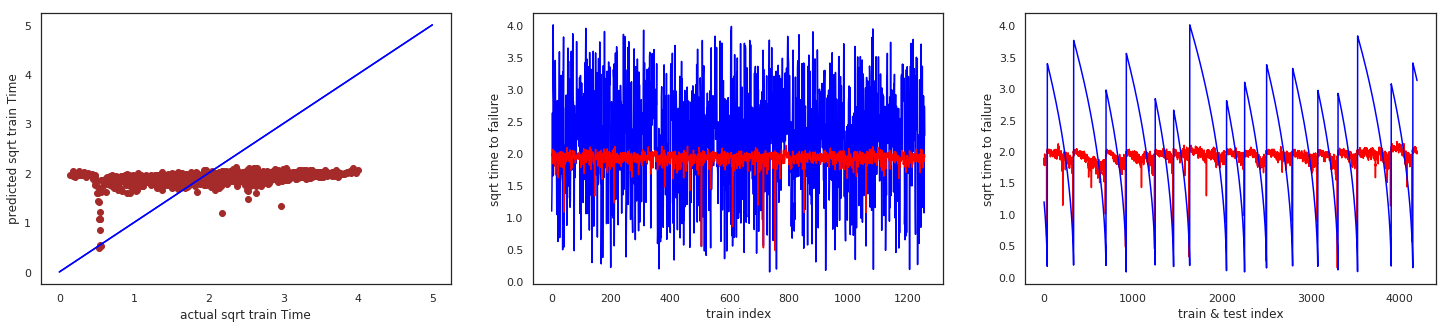

In [64]:
predictions =  gs10.predict(X_PCA_test)
full_predictions = gs10.predict(X_PCA)
print('mean_absolute_error_sqrtTime:', mean_absolute_error(y_test, predictions))
print('r2_score_sqrtTime:', r2_score(y_test, predictions))

fig, axis = plt.subplots(1, 3, figsize=(25,5))
ax1, ax2, ax3 = axis
ax1.set_xlabel('actual sqrt train Time')
ax1.set_ylabel('predicted sqrt train Time')
ax2.set_xlabel('train index')
ax2.set_ylabel('sqrt time to failure')
ax3.set_xlabel('train & test index')
ax3.set_ylabel('sqrt time to failure')
ax1.scatter(y_test.values, predictions, color='brown')
ax1.plot([(0, 0), (5, 5)], [(0, 0), (5, 5)], color='blue')
ax2.plot(y_test.values, color='blue')
ax2.plot(predictions, color='red')
ax3.plot(full_predictions, color='red')
ax3.plot(Y, color='blue')

mean_absolute_error: 3.2000356408255928
r2_score: -0.20947114384346377


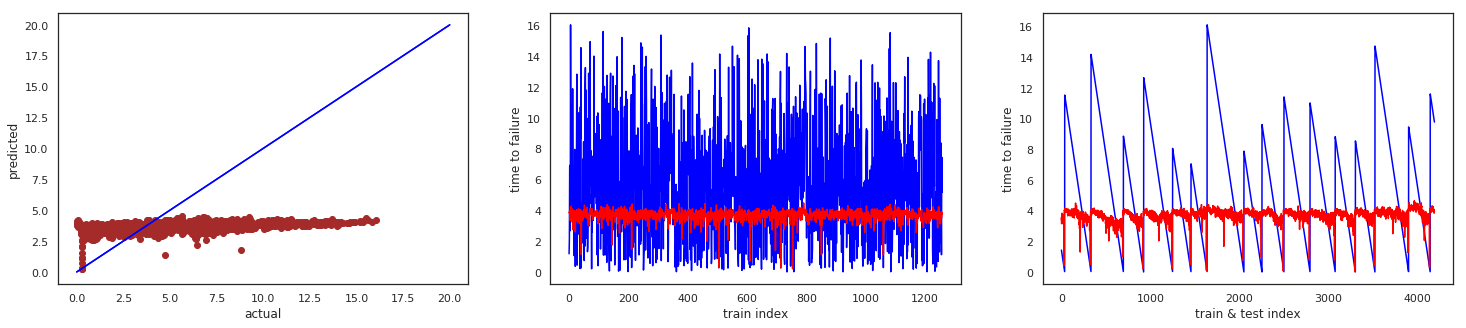

In [65]:
y_predict = np.square(predictions)
y_test_nolog = np.square(y_test)
y_nolog = np.square(Y)
y_nolog_predict = np.square(full_predictions)
print('mean_absolute_error:', mean_absolute_error(y_test_nolog, y_predict))
print('r2_score:', r2_score(y_test_nolog, y_predict))

fig, axis = plt.subplots(1, 3, figsize=(25,5))
ax1, ax2, ax3 = axis
ax1.set_xlabel('actual')
ax1.set_ylabel('predicted')
ax2.set_xlabel('train index')
ax2.set_ylabel('time to failure')
ax3.set_xlabel('train & test index')
ax3.set_ylabel('time to failure')
ax1.scatter(y_test_nolog.values, y_predict, color='brown')
ax1.plot([(0, 0), (20, 20)], [(0, 0), (20, 20)], color='blue')
ax2.plot(y_test_nolog.values, color='blue')
ax2.plot(y_predict, color='red')
ax3.plot(y_nolog, color='blue')
ax3.plot(y_nolog_predict, color='red')

In [66]:
import lightgbm as lgb
import scipy.stats as st

grid = {
     'learning_rate': [0.1, 0.05, 0.01, 0.005],
    'num_leaves': list(range(8, 92, 4)),
    'max_depth': [3, 4, 5, 6, 8, 12, 16, -1],
    'feature_fraction': [0.8, 0.85, 0.9, 0.95, 1],
    'subsample': [0.8, 0.85, 0.9, 0.95, 1],
    'lambda_l1': [0, 0.1, 0.2, 0.4, 0.6, 0.9],
    'lambda_l2': [0, 0.1, 0.2, 0.4, 0.6, 0.9],
    'min_data_in_leaf': [10, 20, 40, 60, 100],
    'min_gain_to_split': [0, 0.001, 0.01, 0.1],
    'random_seed': st.randint(10, 100),
    }
#params = grid_search_cv(RandomForestRegressor(criterion='mse', n_estimators=50),
                        #grid, X_train_scaled, target)
rfr = lgb.LGBMRegressor(n_estimators=10000)
gs11 = RandomizedSearchCV(rfr, param_distributions = grid)  
gs11.fit(X_PCA_train, y_train.values.ravel())  
gs11.best_params_    
#rf_oof = make_predictions(RandomForestRegressor(**params),
                          #X_train_scaled, target)

{'feature_fraction': 0.95,
 'lambda_l1': 0.6,
 'lambda_l2': 0.2,
 'learning_rate': 0.01,
 'max_depth': 5,
 'min_data_in_leaf': 100,
 'min_gain_to_split': 0.1,
 'num_leaves': 36,
 'random_seed': 64,
 'subsample': 0.9}

mean_absolute_error_sqrtTime: 0.49472398869104023
r2_score_sqrtTime: 0.4260003409560357


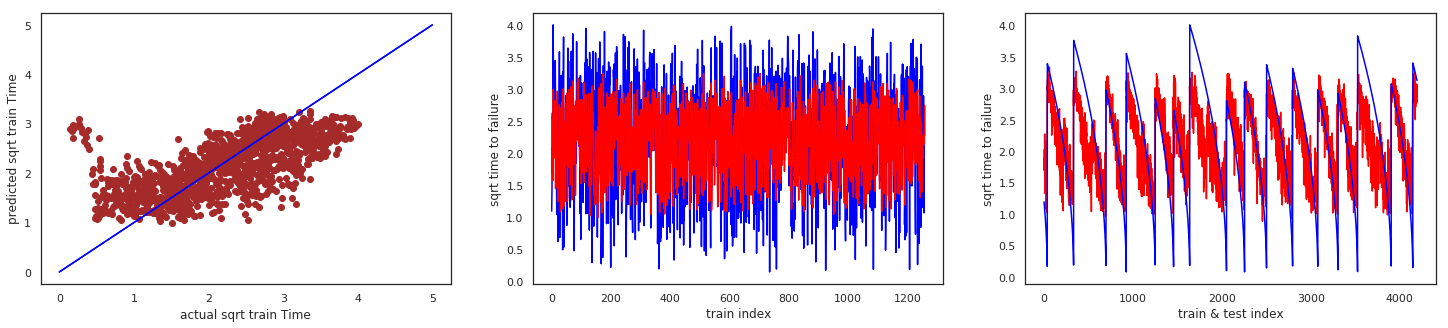

In [67]:
predictions =  gs11.predict(X_PCA_test)
full_predictions = gs11.predict(X_PCA)
print('mean_absolute_error_sqrtTime:', mean_absolute_error(y_test, predictions))
print('r2_score_sqrtTime:', r2_score(y_test, predictions))

fig, axis = plt.subplots(1, 3, figsize=(25,5))
ax1, ax2, ax3 = axis
ax1.set_xlabel('actual sqrt train Time')
ax1.set_ylabel('predicted sqrt train Time')
ax2.set_xlabel('train index')
ax2.set_ylabel('sqrt time to failure')
ax3.set_xlabel('train & test index')
ax3.set_ylabel('sqrt time to failure')
ax1.scatter(y_test.values, predictions, color='brown')
ax1.plot([(0, 0), (5, 5)], [(0, 0), (5, 5)], color='blue')
ax2.plot(y_test.values, color='blue')
ax2.plot(predictions, color='red')
ax3.plot(full_predictions, color='red')
ax3.plot(Y, color='blue')

mean_absolute_error: 2.1411595552301237
r2_score: 0.4228887562542256


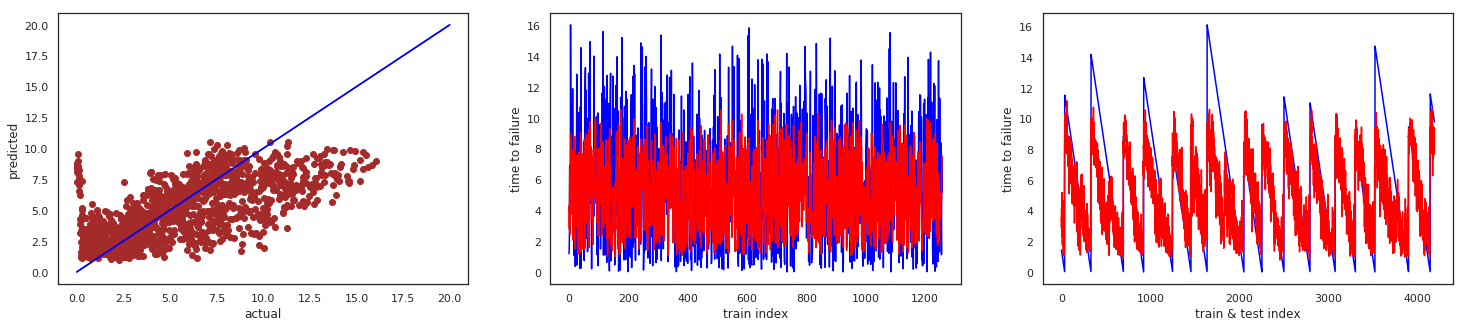

In [68]:
y_predict = np.square(predictions)
y_test_nolog = np.square(y_test)
y_nolog = np.square(Y)
y_nolog_predict = np.square(full_predictions)
print('mean_absolute_error:', mean_absolute_error(y_test_nolog, y_predict))
print('r2_score:', r2_score(y_test_nolog, y_predict))

fig, axis = plt.subplots(1, 3, figsize=(25,5))
ax1, ax2, ax3 = axis
ax1.set_xlabel('actual')
ax1.set_ylabel('predicted')
ax2.set_xlabel('train index')
ax2.set_ylabel('time to failure')
ax3.set_xlabel('train & test index')
ax3.set_ylabel('time to failure')
ax1.scatter(y_test_nolog.values, y_predict, color='brown')
ax1.plot([(0, 0), (20, 20)], [(0, 0), (20, 20)], color='blue')
ax2.plot(y_test_nolog.values, color='blue')
ax2.plot(y_predict, color='red')
ax3.plot(y_nolog, color='blue')
ax3.plot(y_nolog_predict, color='red')

In [69]:
from sklearn import ensemble
from sklearn.ensemble import ExtraTreesRegressor

grid = {
    'max_depth': [6,11,15,20],
    'max_features': ['auto'],
    'min_samples_leaf': [10,16,20,40],
    'min_samples_split': [50,98,150,200],
    'n_estimators': [100, 200, 495,1000],
    'min_weight_fraction_leaf':  st.uniform(0, 0.5)
    }

etr = ExtraTreesRegressor(criterion='mae')
gs12 = RandomizedSearchCV(etr, param_distributions = grid)  
gs12.fit(X_PCA_train, y_train.values.ravel())  
gs12.best_params_ 

{'max_depth': 11,
 'max_features': 'auto',
 'min_samples_leaf': 16,
 'min_samples_split': 50,
 'min_weight_fraction_leaf': 0.052541809298985165,
 'n_estimators': 100}

mean_absolute_error_sqrtTime: 0.5339088200519159
r2_score_sqrtTime: 0.3553593318730728


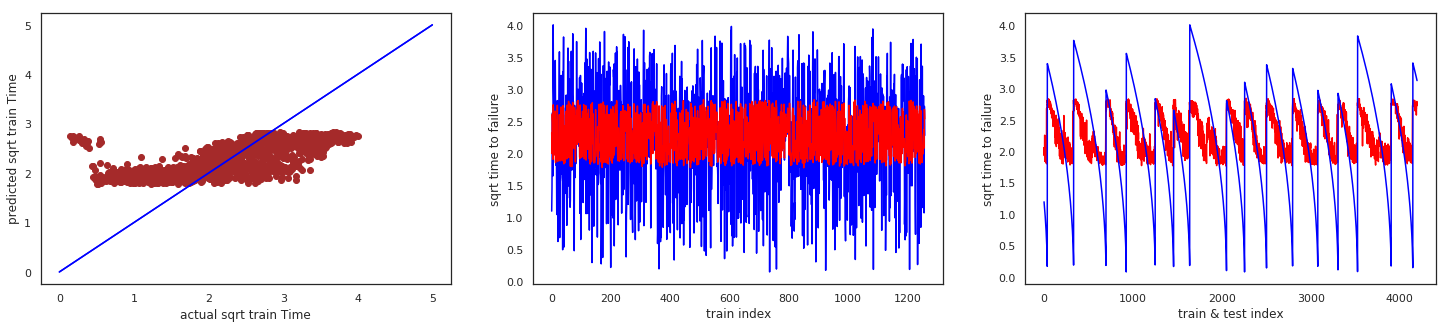

In [70]:
predictions =  gs12.predict(X_PCA_test)
full_predictions = gs12.predict(X_PCA)
print('mean_absolute_error_sqrtTime:', mean_absolute_error(y_test, predictions))
print('r2_score_sqrtTime:', r2_score(y_test, predictions))

fig, axis = plt.subplots(1, 3, figsize=(25,5))
ax1, ax2, ax3 = axis
ax1.set_xlabel('actual sqrt train Time')
ax1.set_ylabel('predicted sqrt train Time')
ax2.set_xlabel('train index')
ax2.set_ylabel('sqrt time to failure')
ax3.set_xlabel('train & test index')
ax3.set_ylabel('sqrt time to failure')
ax1.scatter(y_test.values, predictions, color='brown')
ax1.plot([(0, 0), (5, 5)], [(0, 0), (5, 5)], color='blue')
ax2.plot(y_test.values, color='blue')
ax2.plot(predictions, color='red')
ax3.plot(full_predictions, color='red')
ax3.plot(Y, color='blue')

mean_absolute_error: 2.290595643202016
r2_score: 0.378029770227032


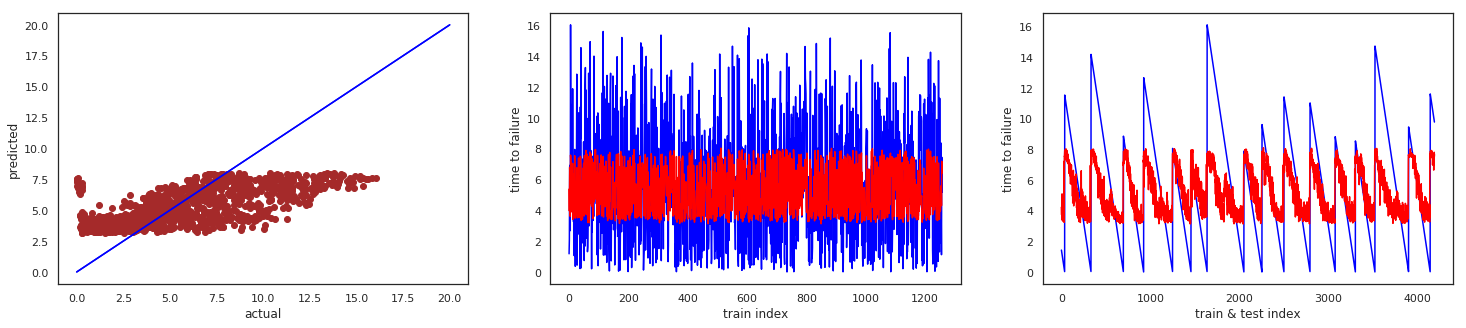

In [71]:
y_predict = np.square(predictions)
y_test_nolog = np.square(y_test)
y_nolog = np.square(Y)
y_nolog_predict = np.square(full_predictions)
print('mean_absolute_error:', mean_absolute_error(y_test_nolog, y_predict))
print('r2_score:', r2_score(y_test_nolog, y_predict))

fig, axis = plt.subplots(1, 3, figsize=(25,5))
ax1, ax2, ax3 = axis
ax1.set_xlabel('actual')
ax1.set_ylabel('predicted')
ax2.set_xlabel('train index')
ax2.set_ylabel('time to failure')
ax3.set_xlabel('train & test index')
ax3.set_ylabel('time to failure')
ax1.scatter(y_test_nolog.values, y_predict, color='brown')
ax1.plot([(0, 0), (20, 20)], [(0, 0), (20, 20)], color='blue')
ax2.plot(y_test_nolog.values, color='blue')
ax2.plot(y_predict, color='red')
ax3.plot(y_nolog, color='blue')
ax3.plot(y_nolog_predict, color='red')

## Submission

In [72]:
submission = pd.read_csv('../input/sample_submission.csv', index_col='seg_id')
X_test = pd.DataFrame(columns=X.columns, dtype=np.float64, index=submission.index)

In [73]:
for seg_id in X_test.index:
    seg = pd.read_csv('../input/test/' + seg_id + '.csv')
    
    x = seg['acoustic_data']  # pd series
            
    I_ave10 = 0.1*len(x)
    II_ave10 = 0.2*len(x)
    III_ave10 = 0.3*len(x)
    IV_ave10 = 0.4*len(x)
    V_ave10 = 0.5*len(x)
    VI_ave10 = 0.6*len(x)
    VII_ave10 = 0.7*len(x)
    VIII_ave10 = 0.8*len(x)
    IX_ave10 = 0.9*len(x)
    
    X_test.loc[seg_id, 'rFFT mean'] = rfft(x).mean()
    X_test.loc[seg_id, 'rFFT std'] = rfft(x).std()
    
    X_test.loc[seg_id, '0<x<5'] = sum(x.between(0, 5))
    X_test.loc[seg_id, '5<x<10'] = sum(x.between(5, 10))    
    X_test.loc[seg_id, '10<x<20'] = sum(x.between(10, 20))
    X_test.loc[seg_id, '20<x<30'] = sum(x.between(20, 30))
    X_test.loc[seg_id, '30<x<100'] = sum(x.between(30, 100))
    X_test.loc[seg_id, '100<x<500'] = sum(x.between(100, 500))
    X_test.loc[seg_id, '500<x<1000'] = sum(x.between(500, 1000))
    X_test.loc[seg_id, '1000<x<5000'] = sum(x.between(1000, 5000))
    
    X_test.loc[seg_id, 'skewness'] = moment(x, moment=3)
    X_test.loc[seg_id, 'kurtosis'] = moment(x, moment=4)
    X_test.loc[seg_id, 'hypermoment'] = moment(x, moment=5)
    X_test.loc[seg_id, 'hypermoment2'] = moment(x, moment=6)
    X_test.loc[seg_id, 'ave'] = x.values.mean()
    X_test.loc[seg_id, 'std'] = x.values.std()
    X_test.loc[seg_id, 'max'] = x.values.max()
    X_test.loc[seg_id, 'min'] = x.values.min()
        
    X_test.loc[seg_id, 'q90'] = np.quantile(x.values, 0.90)
    X_test.loc[seg_id, 'q95'] = np.quantile(x.values, 0.95)
    X_test.loc[seg_id, 'q99'] = np.quantile(x.values, 0.99)
    X_test.loc[seg_id, 'q05'] = np.quantile(x.values, 0.05)
    X_test.loc[seg_id, 'q10'] = np.quantile(x.values, 0.10)
    X_test.loc[seg_id, 'q01'] = np.quantile(x.values, 0.01)
    
    X_test.loc[seg_id, 'abs_max'] = np.abs(x.values).max()
    X_test.loc[seg_id, 'abs_mean'] = np.abs(x.values).mean()
    X_test.loc[seg_id, 'abs_std'] = np.abs(x.values).std()
        
     # New features - rolling features
    for w in [100, 1000, 10000]:
        x_roll_std = x.rolling(w).std().dropna().values
        x_roll_mean = x.rolling(w).mean().dropna().values
        x_roll_abs_mean = x.abs().rolling(w).mean().dropna().values
        
        X_test.loc[seg_id, 'ave_roll_std_' + str(w)] = x_roll_std.mean()
        X_test.loc[seg_id, 'std_roll_std_' + str(w)] = x_roll_std.std()
        X_test.loc[seg_id, 'max_roll_std_' + str(w)] = x_roll_std.max()
        X_test.loc[seg_id, 'min_roll_std_' + str(w)] = x_roll_std.min()
                
        X_test.loc[seg_id, 'ave_roll_mean_' + str(w)] = x_roll_mean.mean()
        X_test.loc[seg_id, 'std_roll_mean_' + str(w)] = x_roll_mean.std()
        X_test.loc[seg_id, 'max_roll_mean_' + str(w)] = x_roll_mean.max()
        X_test.loc[seg_id, 'min_roll_mean_' + str(w)] = x_roll_mean.min()
        
        X_test.loc[seg_id, 'q01_roll_std_' + str(w)] = np.quantile(x_roll_std, 0.01)
        X_test.loc[seg_id, 'q05_roll_std_' + str(w)] = np.quantile(x_roll_std, 0.05)
        X_test.loc[seg_id, 'q10_roll_std_' + str(w)] = np.quantile(x_roll_std, 0.10)
        X_test.loc[seg_id, 'q95_roll_std_' + str(w)] = np.quantile(x_roll_std, 0.95)
        X_test.loc[seg_id, 'q99_roll_std_' + str(w)] = np.quantile(x_roll_std, 0.99)
        X_test.loc[seg_id, 'q01_roll_mean_' + str(w)] = np.quantile(x_roll_mean, 0.01)
        X_test.loc[seg_id, 'q05_roll_mean_' + str(w)] = np.quantile(x_roll_mean, 0.05)
        X_test.loc[seg_id, 'q95_roll_mean_' + str(w)] = np.quantile(x_roll_mean, 0.95)
        X_test.loc[seg_id, 'q99_roll_mean_' + str(w)] = np.quantile(x_roll_mean, 0.99)
        X_test.loc[seg_id, 'ave_roll_abs_mean_' + str(w)] = x_roll_abs_mean.mean()
        X_test.loc[seg_id, 'std_roll_abs_mean_' + str(w)] = x_roll_abs_mean.std()
        X_test.loc[seg_id, 'max_roll_abs_mean_' + str(w)] = x_roll_abs_mean.max()
        X_test.loc[seg_id, 'min_roll_abs_mean_' + str(w)] = x_roll_abs_mean.min()
        X_test.loc[seg_id, 'q01_roll_abs_mean_' + str(w)] = np.quantile(x_roll_abs_mean, 0.01)
        X_test.loc[seg_id, 'q05_roll_abs_mean_' + str(w)] = np.quantile(x_roll_abs_mean, 0.05)
        X_test.loc[seg_id, 'q95_roll_abs_mean_' + str(w)] = np.quantile(x_roll_abs_mean, 0.95)
        X_test.loc[seg_id, 'q99_roll_abs_mean_' + str(w)] = np.quantile(x_roll_abs_mean, 0.99)

In [74]:
X_test.head()

,rFFT mean,rFFT std,0<x<5,5<x<10,10<x<20,20<x<30,30<x<100,100<x<500,500<x<1000,1000<x<5000,skewness,kurtosis,hypermoment,hypermoment2,ave,std,max,min,q90,q95,q99,q05,q10,q01,abs_max,abs_mean,abs_std,ave_roll_std_100,std_roll_std_100,max_roll_std_100,min_roll_std_100,ave_roll_mean_100,std_roll_mean_100,max_roll_mean_100,min_roll_mean_100,q01_roll_std_100,q05_roll_std_100,q10_roll_std_100,q95_roll_std_100,q99_roll_std_100,...,q10_roll_std_1000,q95_roll_std_1000,q99_roll_std_1000,q01_roll_mean_1000,q05_roll_mean_1000,q95_roll_mean_1000,q99_roll_mean_1000,ave_roll_abs_mean_1000,std_roll_abs_mean_1000,max_roll_abs_mean_1000,min_roll_abs_mean_1000,q01_roll_abs_mean_1000,q05_roll_abs_mean_1000,q95_roll_abs_mean_1000,q99_roll_abs_mean_1000,ave_roll_std_10000,std_roll_std_10000,max_roll_std_10000,min_roll_std_10000,ave_roll_mean_10000,std_roll_mean_10000,max_roll_mean_10000,min_roll_mean_10000,q01_roll_std_10000,q05_roll_std_10000,q10_roll_std_10000,q95_roll_std_10000,q99_roll_std_10000,q01_roll_mean_10000,q05_roll_mean_10000,q95_roll_mean_10000,q99_roll_mean_10000,ave_roll_abs_mean_10000,std_roll_abs_mean_10000,max_roll_abs_mean_10000,min_roll_abs_mean_10000,q01_roll_abs_mean_10000,q05_roll_abs_mean_10000,q95_roll_abs_mean_10000,q99_roll_abs_mean_10000
seg_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
seg_00030f,7.64721932,2196.00949663,78785.0,65363.0,12683.0,815.0,282.0,5.0,0.0,0.0,38.42838420,18258.54414315,4.95616340e+05,9.14320391e+07,4.49178000,4.89367337,115.0,-75.0,9.0,11.0,18.0,-2.0,0.0,-8.0,115.0,5.22460667,4.10214722,4.02240475,2.79923249,50.48999801,2.01509455,4.49171780,0.41992686,10.42,-0.22,2.34367837,2.51498539,2.61858162,8.36222265,16.02642704,...,2.80897158,8.50825607,13.15595219,3.889,4.099,4.867,5.000,5.22353440,1.32368956,17.949,4.041,4.170,4.336,7.344,10.659,4.61890293,1.52412686,8.75936039,2.90603312,4.50419985,0.14227843,4.8284,4.2075,2.92834655,3.06546532,3.19084031,8.64530577,8.70485422,4.2187,4.2626,4.7406,4.8027,5.21994953,0.55070799,6.5387,4.4246,4.4583,4.5291,6.4503,6.5126
seg_0012b5,2.73337817,2289.26975720,82477.0,60687.0,10553.0,990.0,615.0,13.0,0.0,0.0,61.43898904,72872.00998562,1.02341800e+06,6.99589249e+08,4.17115333,5.92281970,152.0,-140.0,9.0,11.0,20.0,-2.0,-1.0,-12.0,152.0,5.19834000,5.04535178,4.26996136,4.12163087,58.37331184,2.03690694,4.17146964,0.47043111,11.90,-3.45,2.31104069,2.47565928,2.57485902,9.95472580,24.17315273,...,2.77205489,10.93334611,24.33134697,3.644,3.790,4.541,4.739,5.20434440,2.12030097,21.466,3.727,3.911,4.106,8.549,16.584,5.57567472,2.36485649,11.59617045,3.18865052,4.17864109,0.14384385,4.4692,3.8827,3.21930679,3.32692213,3.44485975,10.04478182,11.57258365,3.8925,3.9391,4.3813,4.4531,5.24931734,0.78063362,7.6795,4.3232,4.3460,4.3784,6.5270,7.6511
seg_00184e,5.96271171,2609.15062124,78734.0,67883.0,11911.0,901.0,684.0,46.0,0.0,0.0,143.72190617,384557.92914548,1.37079040e+07,1.17708102e+10,4.61026000,6.94696692,248.0,-193.0,9.0,11.0,20.0,-2.0,0.0,-11.0,248.0,5.59719333,6.17950431,4.30122732,5.47717250,106.29673494,1.97458601,4.61048579,0.52098089,19.11,-4.96,2.31254812,2.47563888,2.56193976,8.87035694,26.88560690,...,2.74014368,10.08499932,31.07539342,4.013,4.215,4.966,5.082,5.60482381,2.88574610,37.621,4.112,4.337,4.444,8.164,20.155,5.86872265,4.03302787,20.35347701,2.98775832,4.62216050,0.15417999,4.9169,4.2381,3.00526574,3.06534429,3.13905348,17.37385061,20.32975698,4.2515,4.3837,4.8675,4.9035,5.65221984,1.20165227,10.6715,4.6045,4.6614,4.7050,8.6186,10.6432
seg_003339,4.00235192,2085.56426267,85895.0,70567.0,7907.0,417.0,220.0,0.0,0.0,0.0,4.30969579,12674.54659812,-5.77161047e+04,4.60813365e+07,4.53147333,4.11413289,85.0,-93.0,8.0,10.0,14.0,-1.0,1.0,-5.0,93.0,4.96148667,3.58385129,3.32310117,2.43110083,45.89514950,1.88947109,4.53159672,0.38652922,9.18,-0.06,2.24578168,2.38047614,2.45893547,6.10688467,14.29024885,...,2.64349618,6.96742140,11.79655979,4.032,4.184,4.911,5.051,4.96481999,1.10341626,16.835,4.101,4.210,4.337,6.480,9.077

In [75]:
X_test_scaled = scl_obj.fit_transform(X_test)

In [76]:
predictions = gs6.predict(X_test_scaled)
submission['time_to_failure'] = np.square(predictions)
submission[submission < 0] = 0

In [77]:
submission.head()

,time_to_failure
seg_id,
seg_00030f,3.63680061
seg_0012b5,4.65315428
seg_00184e,5.35374253
seg_003339,8.45800407
seg_0042cc,7.14779621


In [78]:
submission.to_csv('submission_ExtraTreesRegressor.csv')